# Ask Wikipedia Anything: RAG for English & French

*************************************************
## Import Libraries
*************************************************

In [3]:
%matplotlib inline
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import os
from tqdm import tqdm
from datetime import datetime
import re
from wordcloud import WordCloud
import networkx as nx
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100
sns.set(style="whitegrid")

import warnings
warnings.filterwarnings("ignore")

try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

## Load the Data



In [4]:
def read_jsonl(file_path, max_records=None):
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for i, line in enumerate(tqdm(f)):
            if max_records and i >= max_records:
                break
            data.append(json.loads(line))
    return data

In [5]:
import kagglehub

directory = kagglehub.dataset_download("wikimedia-foundation/wikipedia-structured-contents")
file_path = directory+"/enwiki_namespace_0/enwiki_namespace_0_0.jsonl"
data = read_jsonl(file_path)
print(f"Successfully loaded {len(data)} records")

309509it [01:07, 4563.02it/s]

Successfully loaded 309509 records


In [6]:
df = pd.DataFrame(data)
print(f"Dataset shape: {df.shape}")
print("\nColumns in the dataset:")
for col in df.columns:
    print(f"- {col}")

Dataset shape: (309509, 17)

Columns in the dataset:
- name
- identifier
- version
- event
- url
- date_created
- date_modified
- is_part_of
- in_language
- license
- description
- sections
- abstract
- main_entity
- additional_entities
- infoboxes
- image


In [7]:
df.head()

,name,identifier,version,event,url,date_created,date_modified,is_part_of,in_language,license,description,sections,abstract,main_entity,additional_entities,infoboxes,image
0,Not Again SU,76716259,"{'identifier': 1220413474, 'comment': 'Added #...",{'identifier': 'fa3cae5b-8707-4f55-9fab-5baa4c...,https://en.wikipedia.org/wiki/Not_Again_SU,2024-04-23T16:50:32Z,2024-04-23T16:53:55Z,"{'identifier': 'enwiki', 'url': 'https://en.wi...",{'identifier': 'en'},[{'name': 'Creative Commons Attribution-ShareA...,"Student organization in Syracuse, New York","[{'type': 'section', 'name': 'Abstract'}, {'ty...",NaN,NaN,NaN,NaN,NaN
1,Mike Ross (Suits),76727681,"{'identifier': 1220574416, 'comment': 'Request...",{'identifier': '22366970-ddf7-43dc-8cec-941de1...,https://en.wikipedia.org/wiki/Mike_Ross_(Suits),2024-04-24T17:12:05Z,2024-04-24T17:14:10Z,"{'identifier': 'enwiki', 'url': 'https://en.wi...",{'identifier': 'en'},[{'name': 'Creative Commons Attribution-ShareA...,An American Legal drama series from 2011-2019,"[{'type': 'section', 'name': 'Abstract', 'has_...",REDIRECT List of Suits characters#Mike Ross,"{'identifier': 'Q125388612', 'url': 'https://w...","[{'identifier': 'Q125388612', 'url': 'https://...",NaN,NaN
2,Second Polish republic,76744378,"{'identifier': 1220875620, 'comment': '[[WP:AE...",{'identifier': '552624d6-5c55-45ef-a8e3-945335...,https://en.wikipedia.org/wiki/Second_Polish_re...,2024-04-26T13:30:10Z,2024-04-26T13:30:10Z,"{'identifier': 'enwiki', 'url': 'https://en.wi...",{'identifier': 'en'},[{'name': 'Creative Commons Attribution-ShareA...,Country in Central and Eastern Europe (1918–1939),"[{'type': 'section', 'name': 'Abstract', 'has_...",REDIRECT #Second Polish Republic,NaN,NaN,NaN,NaN
3,Left-to-right script,76735997,"{'identifier': 1220716997, 'comment': 'create ...",{'identifier': 'aae6c4ee-bf95-4dc0-942d-5eea53...,https://en.wikipedia.org/wiki/Left-to-right_sc...,2024-04-25T13:58:39Z,2024-04-25T13:58:39Z,"{'identifier': 'enwiki', 'url': 'https://en.wi...",{'identifier': 'en'},[{'name': 'Creative Commons Attribution-ShareA...,Convention of symbols representing language,"[{'type': 'section', 'name': 'Abstract', 'has_...",REDIRECT Writing system#Directionality,NaN,NaN,NaN,NaN
4,1442 in France,58128987,"{'identifier': 1145356533, 'comment': 'Alter: ...",{'identifier': 'c4526432-0a4a-42ed-8ef7-54827c...,https://en.wikipedia.org/wiki/1442_in_France,NaN,2023-03-18T18:38:51Z,"{'identifier': 'enwiki', 'url': 'https://en.wi...",{'identifier': 'en'},[{'name': 'Creative Commons Attribution-ShareA...,List of events in the year 1442,"[{'type': 'section', 'name': 'Abstract', 'has_...",Events from the year 1442 in France,"{'identifier': 'Q56292328', 'url': 'https://ww...","[{'identifier': 'Q56292328', 'url': 'https://w...","[{'type': 'infobox', 'name': 'Year in France h...",NaN


## Exploratory Data Analysis (EDA)

* **Missing Value Analysis**

In [8]:
def missing_value_analysis(df):
    """
    Analyzes and visualizes missing values in a Pandas DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame to analyze.
    """
    missing_counts = df.isnull().sum().sort_values(ascending=False)
    missing_percentage = (df.isnull().sum() / len(df)).sort_values(ascending=False)
    missing_data = pd.concat([missing_counts, missing_percentage], axis=1, keys=['Count', 'Percentage'])
    print("Missing Data Analysis:")
    print(missing_data)

    plt.figure(figsize=(12, 8))
    sns.barplot(x=missing_data.index, y=missing_data['Percentage'])
    plt.xticks(rotation=90)
    plt.title('Percentage of Missing Values by Column', fontsize=14, fontweight='bold', color='#d4558f')
    plt.xlabel('Columns', fontsize=12, fontweight='bold', color='#36427e')
    plt.ylabel('Percentage', fontsize=12, fontweight='bold', color='#36427e')
    plt.tight_layout()
    plt.gca().set_facecolor('#fffdd0')
    plt.grid(False)
    plt.show()



Missing Data Analysis:
                      Count  Percentage
date_created         309209    0.999031
image                218902    0.707256
infoboxes             97441    0.314824
description           56858    0.183704
abstract                505    0.001632
main_entity             381    0.001231
additional_entities     376    0.001215
sections                 62    0.000200
name                      0    0.000000
in_language               0    0.000000
is_part_of                0    0.000000
date_modified             0    0.000000
url                       0    0.000000
version                   0    0.000000
event                     0    0.000000
identifier                0    0.000000
license                   0    0.000000


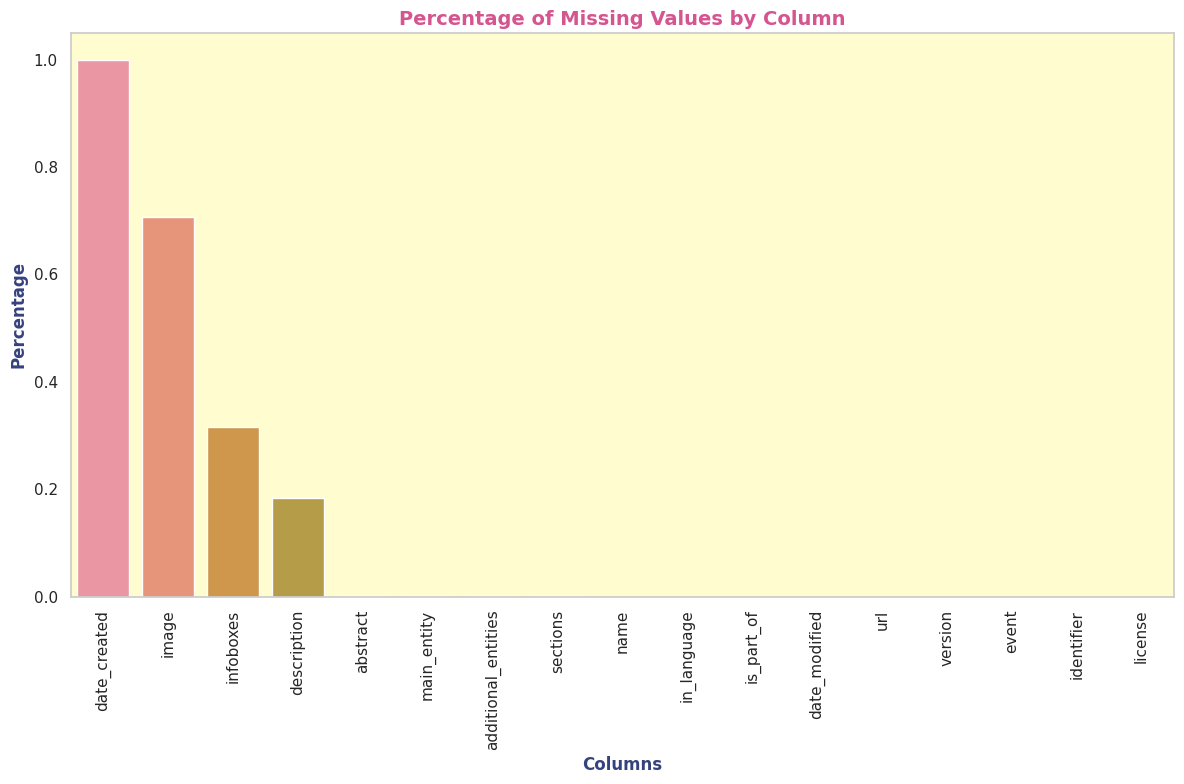

In [9]:
missing_value_analysis(df)

* **Distribution of Article Lengths (Description)**

In [10]:
def analyze_description_length(df):
    """
    Analyzes and visualizes the distribution of article description lengths.

    Args:
        df (pd.DataFrame): The DataFrame containing the article descriptions.
    """
    df['description_length'] = df['description'].str.len()
    df_no_na = df.dropna(subset=['description_length'])
    plt.figure(figsize=(12, 6))
    sns.histplot(df_no_na['description_length'], bins=50, kde=True)
    plt.title('Distribution of Article Description Lengths', fontsize=14, fontweight='bold', color='#36427e')
    plt.xlabel('Description Length', fontsize=12, fontweight='bold', color='darkorange')
    plt.ylabel('Frequency', fontsize=12, fontweight='bold', color='darkorange')
    plt.gca().set_facecolor('#fffdd0')
    plt.grid(False)
    plt.show()

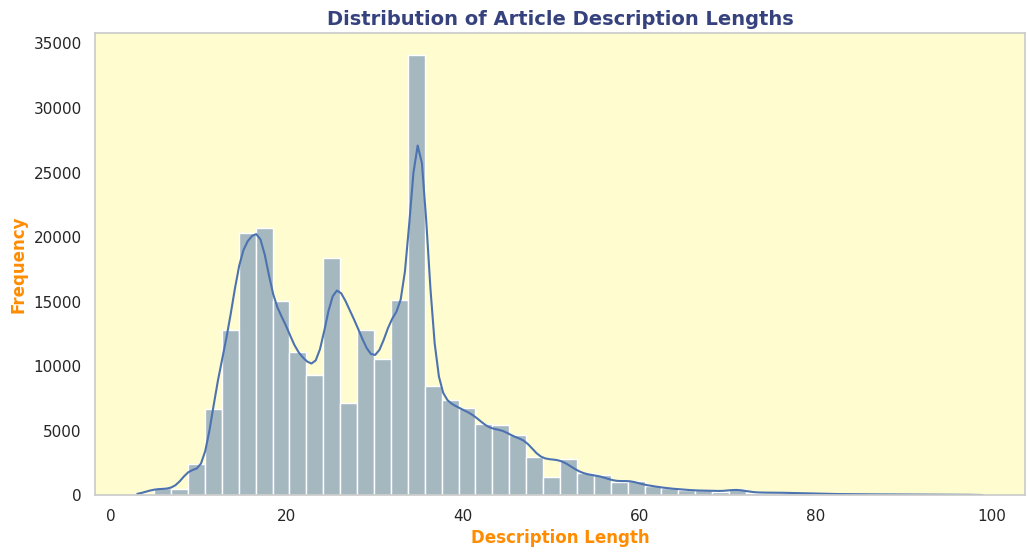

In [11]:
analyze_description_length(df)

* **Article Creation Over Time**

In [12]:
def analyze_article_creation_over_time(df):
    """
    Analyzes and visualizes the number of articles created over time.

    Args:
        df (pd.DataFrame): The DataFrame containing the article creation dates.
    """
    # Convert 'date_created' to datetime objects, handling potential errors
    df['date_created'] = pd.to_datetime(df['date_created'], errors='coerce')

    # Drop rows where 'date_created' is NaT (Not a Time)
    df = df.dropna(subset=['date_created'])

    # Extract the year from the 'date_created' column
    df['creation_year'] = df['date_created'].dt.year

    # Group by year and count the number of articles created each year
    articles_per_year = df['creation_year'].value_counts().sort_index()

    # Create the plot
    plt.figure(figsize=(12, 6))
    articles_per_year.plot(kind='line', marker='o')
    plt.title('Number of Articles Created Over Time', fontsize=14, fontweight='bold', color='#981414')
    plt.xlabel('Year', fontsize=12, fontweight='bold', color='#8ecae6')
    plt.ylabel('Number of Articles', fontsize=12, fontweight='bold', color='#8ecae6')
    plt.gca().set_facecolor('#fffdd0')
    plt.grid(False)
    plt.show()

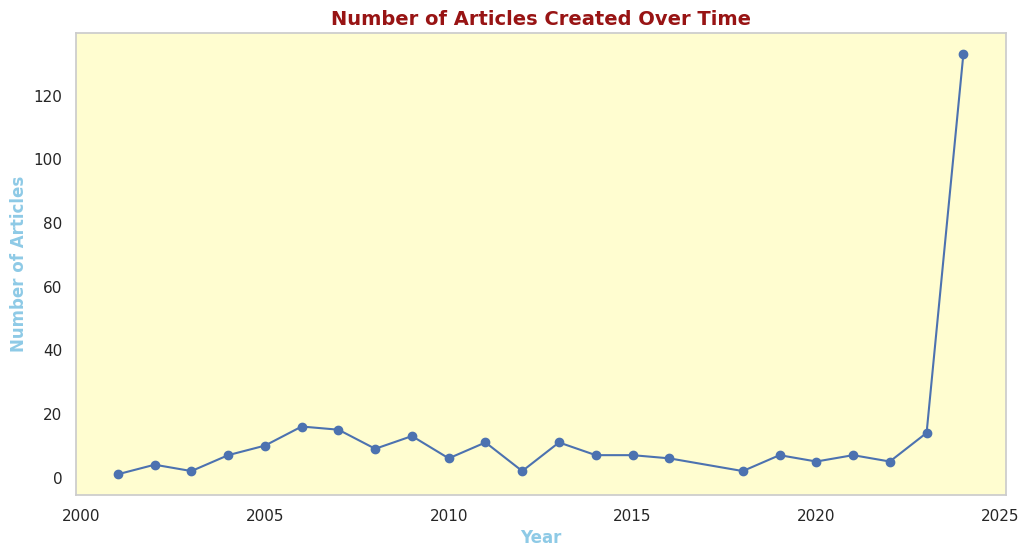

In [13]:
analyze_article_creation_over_time(df)

* **Distribution of Section Counts**

In [14]:
def analyze_section_counts(df):
    """
    Analyzes and visualizes the distribution of the number of sections in each article.

    Args:
        df (pd.DataFrame): The DataFrame containing the 'sections' column.
    """
    # Function to count sections, handling missing or non-list values
    def count_sections(sections):
        if isinstance(sections, list):
            return len(sections)
        else:
            return 0  # Return 0 for missing or non-list values

    # Apply the function to the 'sections' column to create 'section_count'
    df['section_count'] = df['sections'].apply(count_sections)

    # Plotting the distribution
    plt.figure(figsize=(12, 6))
    sns.histplot(df['section_count'], bins=50, kde=True)
    plt.title('Distribution of Section Counts in Articles', fontsize=14, fontweight='bold', color='#219ebc')
    plt.xlabel('Number of Sections', fontsize=12, fontweight='bold', color='#981414')
    plt.ylabel('Frequency', fontsize=12, fontweight='bold', color='#981414')
    plt.xlim(0, 100)  # Limit x-axis for better readability
    plt.gca().set_facecolor('#fffdd0')
    plt.grid(False)
    plt.show()

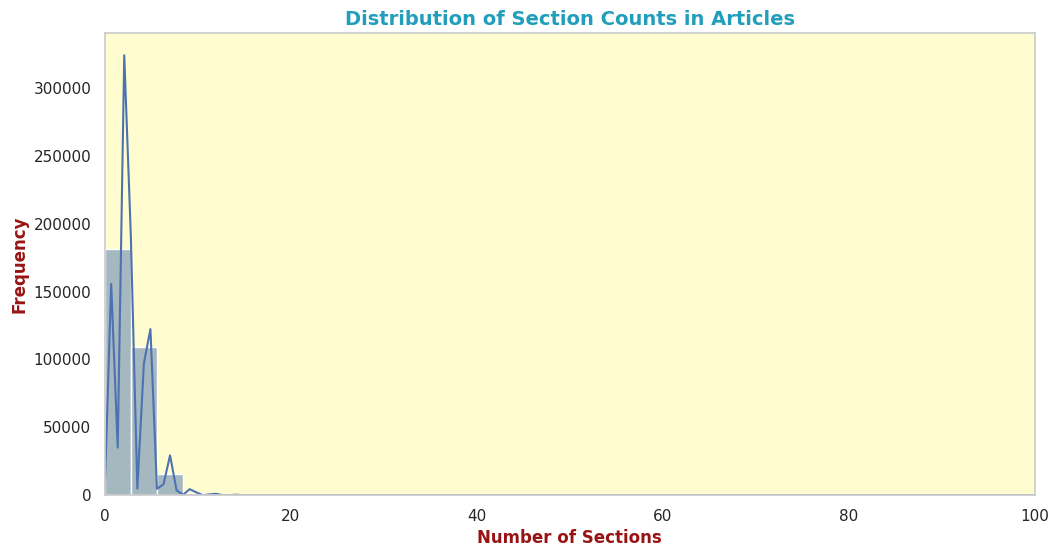

In [15]:
analyze_section_counts(df)

* **Article Modification Over Time**

In [16]:
def analyze_article_modifications_over_time(df):
    """
    Analyzes and visualizes the number of article modifications over time.
    """
    df['date_modified'] = pd.to_datetime(df['date_modified'], errors='coerce')
    df = df.dropna(subset=['date_modified'])
    df['modification_year'] = df['date_modified'].dt.year
    modifications_per_year = df['modification_year'].value_counts().sort_index()

    plt.figure(figsize=(12, 6))
    modifications_per_year.plot(kind='line', marker='o')
    plt.title('Number of Article Modifications Over Time', fontsize=14, fontweight='bold', color='#219ebc')
    plt.xlabel('Year', fontsize=12, fontweight='bold', color='#981414')
    plt.ylabel('Number of Modifications', fontsize=12, fontweight='bold', color='#981414')
    plt.gca().set_facecolor('#fffdd0')
    plt.grid(False)
    plt.show()


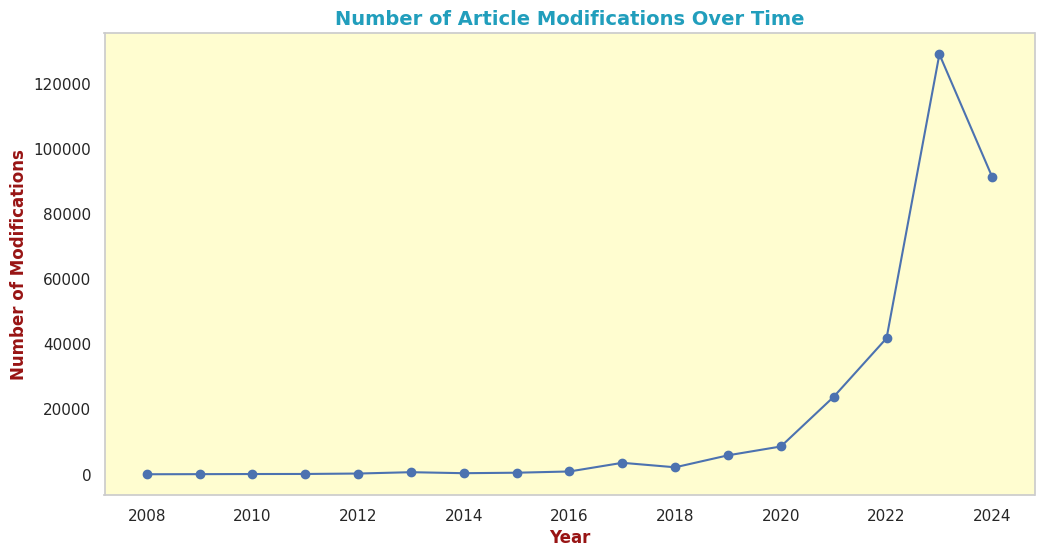

In [17]:
analyze_article_modifications_over_time(df)

* **Distribution of Description Word Counts**

In [18]:
def analyze_description_word_counts(df):
    """
    Analyzes and visualizes the distribution of word counts in the 'description' column.
    """
    df['description_word_count'] = df['description'].str.split().str.len()
    df_no_na = df.dropna(subset=['description_word_count'])

    plt.figure(figsize=(12, 6))
    sns.histplot(df_no_na['description_word_count'], bins=50, kde=True)
    plt.title('Distribution of Word Counts in Article Descriptions', fontsize=14, fontweight='bold', color='#981414')
    plt.xlabel('Word Count', fontsize=12, fontweight='bold', color='#219ebc')
    plt.ylabel('Frequency', fontsize=12, fontweight='bold', color='#219ebc')
    plt.xlim(0, 150)  # Limit x-axis for better readability
    plt.gca().set_facecolor('#fffdd0')
    plt.grid(False)
    plt.show()

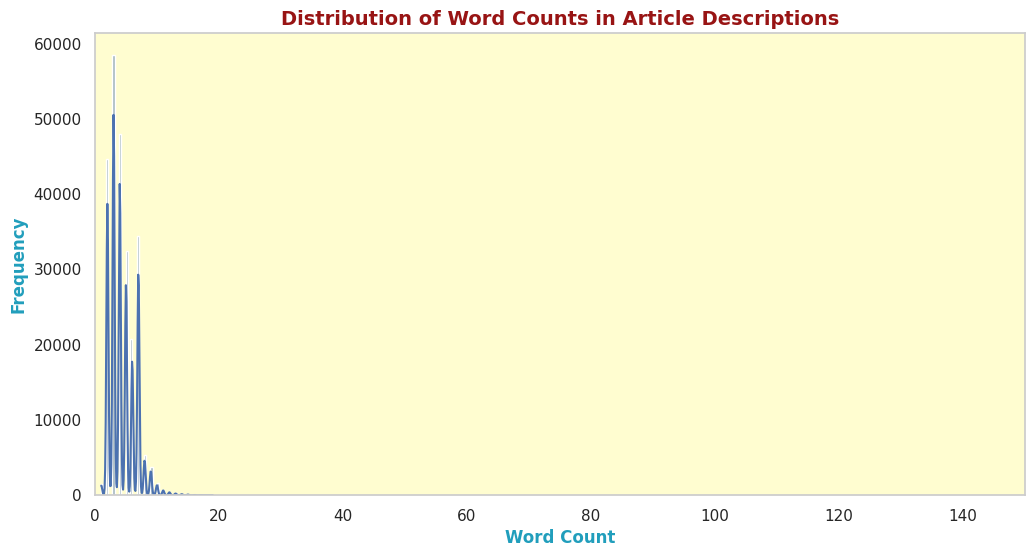

In [19]:
analyze_description_word_counts(df)

* **Analysis of main_entity identifiers**

In [20]:
def analyze_main_entity_identifiers(df):
    """
    Analyzes and visualizes the distribution of main entity identifiers.
    """
    # Extract main entity identifiers
    df['main_entity_id'] = df['main_entity'].apply(lambda x: x['identifier'] if isinstance(x, dict) else None)

    # Count occurrences of each identifier
    entity_counts = df['main_entity_id'].value_counts().nlargest(10)

    # Create bar plot
    plt.figure(figsize=(12, 6))
    sns.barplot(x=entity_counts.index, y=entity_counts.values, palette="magma")
    plt.title('Top 10 Main Entity Identifiers', fontsize=14, fontweight='bold', color='#b557a8')
    plt.xlabel('Main Entity Identifier')
    plt.ylabel('Number of Articles')
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.gca().set_facecolor('#fffdd0')
    plt.grid(False)
    plt.show()

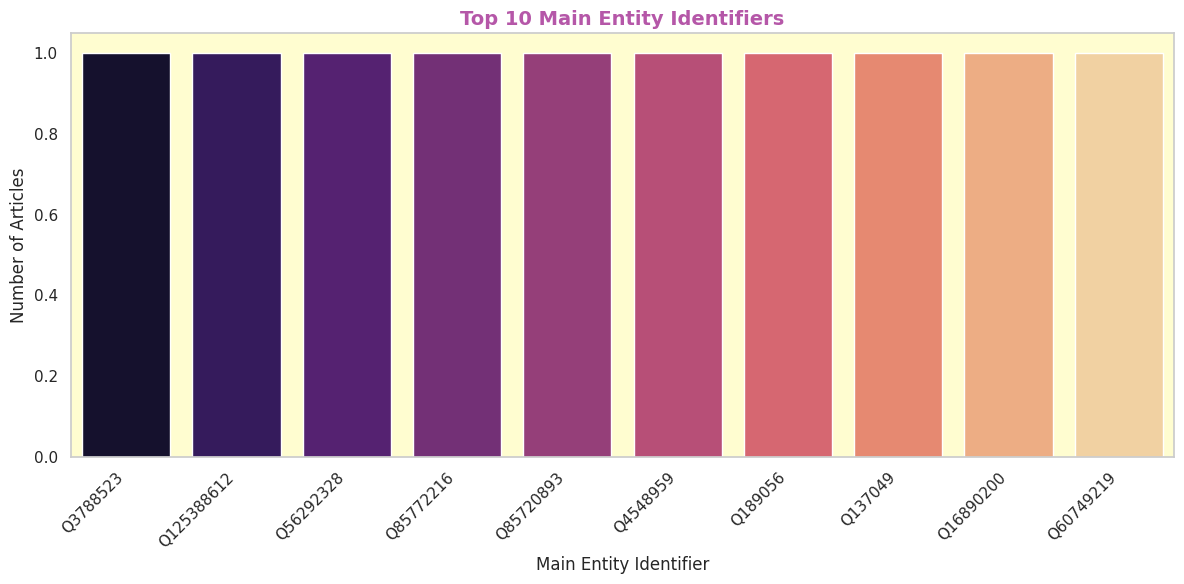

In [21]:
analyze_main_entity_identifiers(df)

* **Relationship between description length and number of sections**

In [22]:
def analyze_description_length_vs_section_count(df):
    """
    Analyzes the relationship between the length of the description and the number of sections in an article.
    """

    # Ensure 'description_length' and 'section_count' exist
    if 'description_length' not in df.columns:
        df['description_length'] = df['description'].str.len()
    if 'section_count' not in df.columns:
        def count_sections(sections):
            if isinstance(sections, list):
                return len(sections)
            else:
                return 0
        df['section_count'] = df['sections'].apply(count_sections)

    # Remove rows with missing values in either column
    df_no_na = df.dropna(subset=['description_length', 'section_count'])

    # Create a scatter plot
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x=df_no_na['description_length'], y=df_no_na['section_count'], alpha=0.5)
    plt.title('Relationship between Description Length and Number of Sections', fontsize=14, fontweight='bold', color='#b557a8')
    plt.xlabel('Description Length')
    plt.ylabel('Number of Sections')
    plt.xlim(0, 500)  # Limit x-axis for better readability
    plt.ylim(0, 50)   # Limit y-axis for better readability
    plt.gca().set_facecolor('#fffdd0')
    plt.grid(False)
    plt.show()

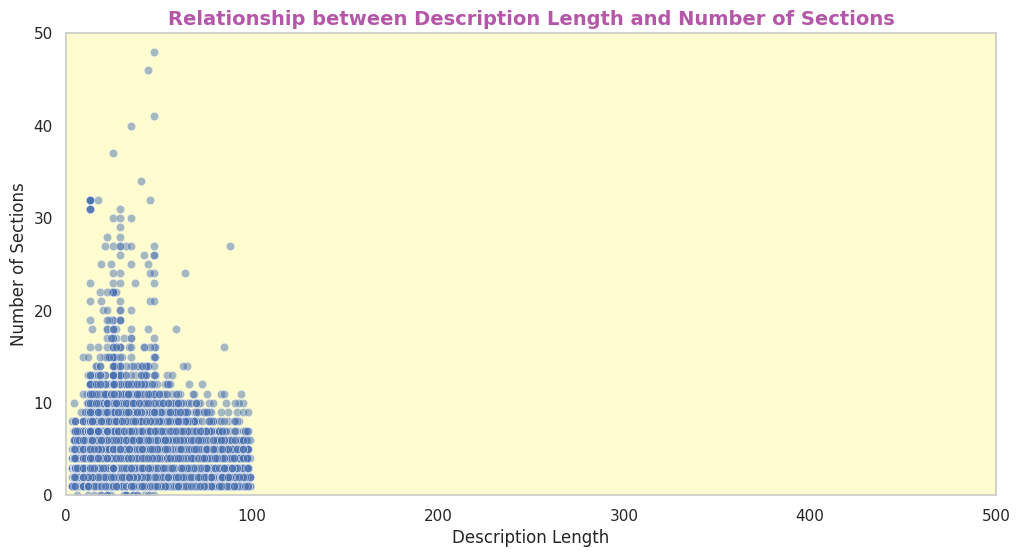

In [23]:
analyze_description_length_vs_section_count(df)

* **Convert date columns**

In [24]:
df['date_created'] = pd.to_datetime(df['date_created'], errors='coerce')
df['date_modified'] = pd.to_datetime(df['date_modified'], errors='coerce')

* **Plot creation and modification trends**

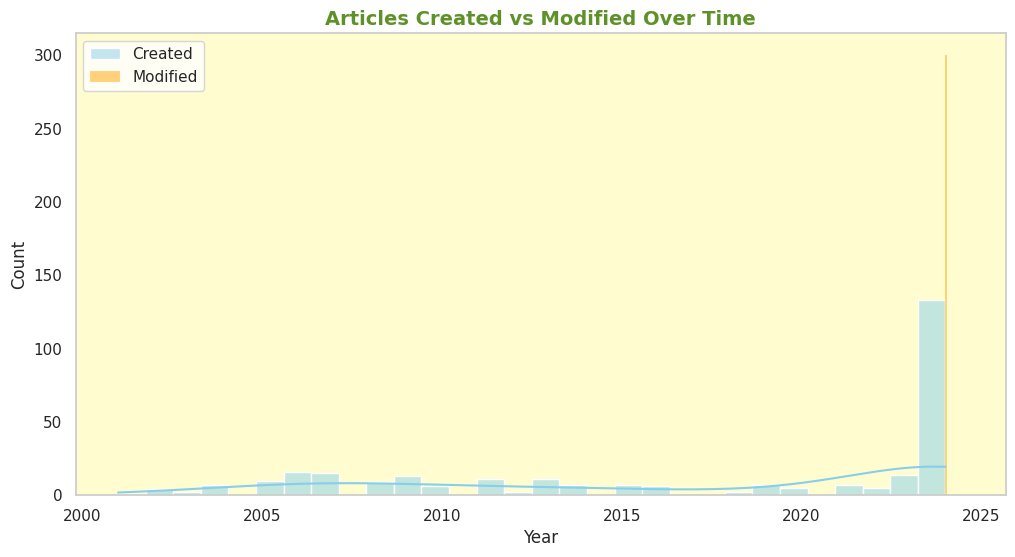

In [25]:
df_dates = df[['date_created', 'date_modified']].dropna()
df_dates['created_year'] = df_dates['date_created'].dt.year
df_dates['modified_year'] = df_dates['date_modified'].dt.year

# Plotting
plt.figure(figsize=(12,6))
sns.histplot(df_dates['created_year'], bins=30, color='skyblue', label='Created', kde=True)
sns.histplot(df_dates['modified_year'], bins=30, color='orange', label='Modified', kde=True)
plt.title('Articles Created vs Modified Over Time', fontsize=14, fontweight='bold', color='#5e9229')
plt.xlabel('Year')
plt.ylabel('Count')
plt.gca().set_facecolor('#fffdd0')
plt.grid(False)
plt.legend()
plt.show()

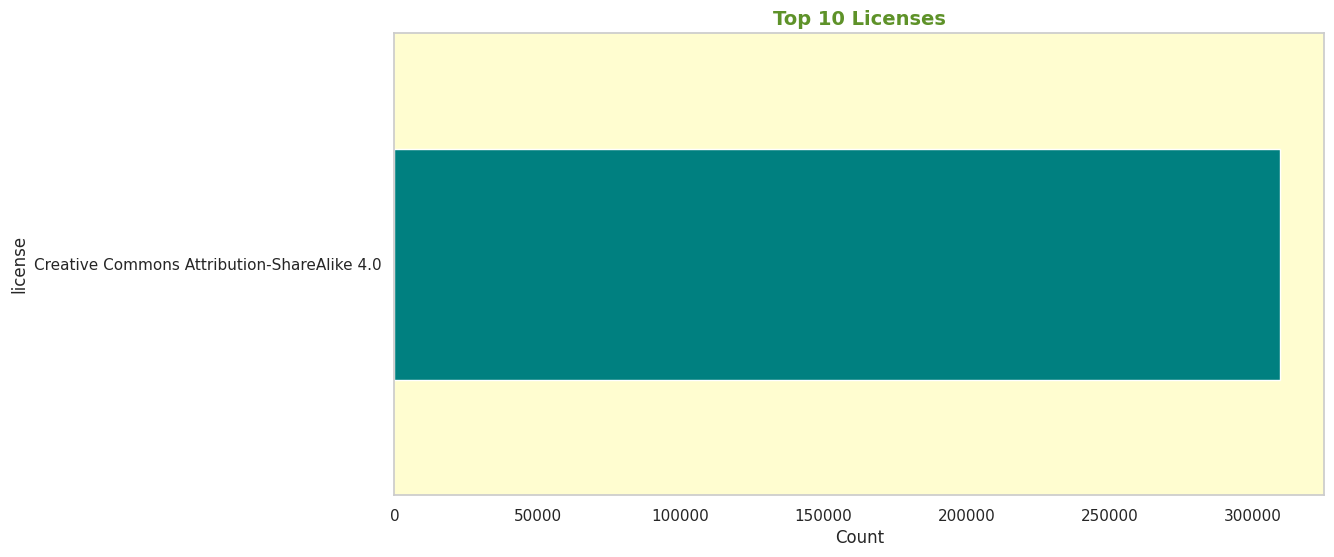

In [26]:
license_names = df['license'].dropna().apply(lambda x: ', '.join([l['name'] for l in x]) if isinstance(x, list) else x)
license_counts = license_names.value_counts().head(10)

plt.figure()
license_counts.plot(kind='barh', color='teal')
plt.title('Top 10 Licenses', fontsize=14, fontweight='bold', color='#5e9229')
plt.xlabel('Count')
plt.gca().invert_yaxis()
plt.gca().set_facecolor('#fffdd0')
plt.grid(False)
plt.show()

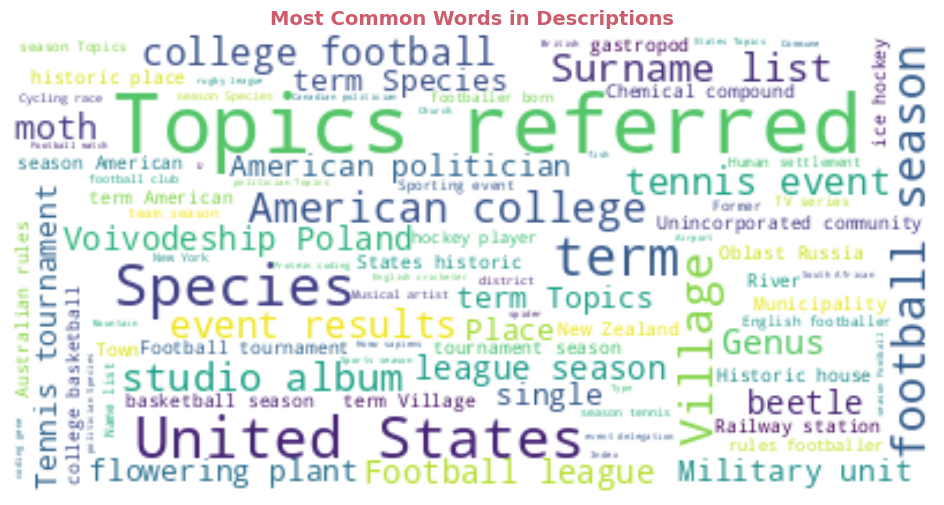

In [27]:
text = ' '.join(df['description'].dropna())
stop_words = set(stopwords.words('english'))
wordcloud = WordCloud(stopwords=stop_words, background_color='white', max_words=200).generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Common Words in Descriptions", fontsize=14, fontweight='bold', color='#cc5c6c')
plt.show()

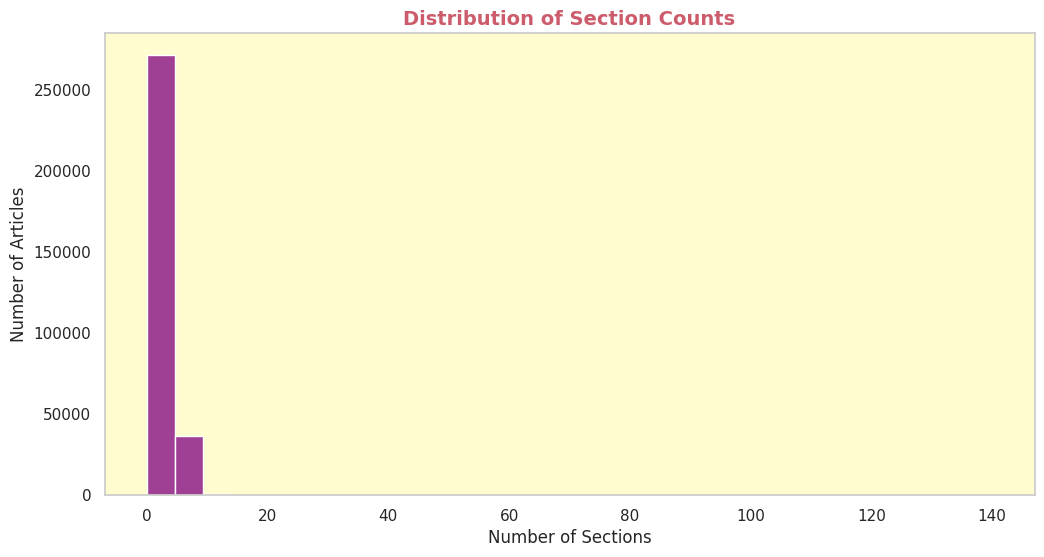

In [28]:
df['num_sections'] = df['sections'].apply(lambda x: len(x) if isinstance(x, list) else 0)

sns.histplot(df['num_sections'], bins=30, color='purple')
plt.title('Distribution of Section Counts', fontsize=14, fontweight='bold', color='#cc5c6c')
plt.xlabel('Number of Sections')
plt.ylabel('Number of Articles')
plt.gca().set_facecolor('#fffdd0')
plt.grid(False)
plt.show()

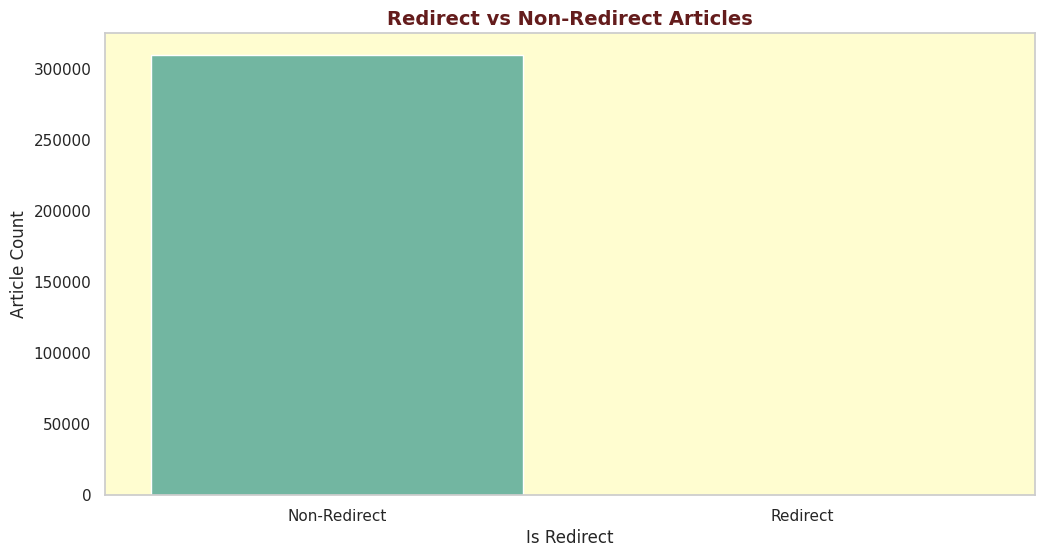

In [29]:
df['is_redirect'] = df['abstract'].astype(str).str.contains("REDIRECT", case=False)

sns.countplot(x='is_redirect', data=df, palette='Set2')
plt.title('Redirect vs Non-Redirect Articles', fontsize=14, fontweight='bold', color='#641c1c')
plt.xlabel('Is Redirect')
plt.ylabel('Article Count')
plt.xticks([0, 1], ['Non-Redirect', 'Redirect'])
plt.gca().set_facecolor('#fffdd0')
plt.grid(False)
plt.show()

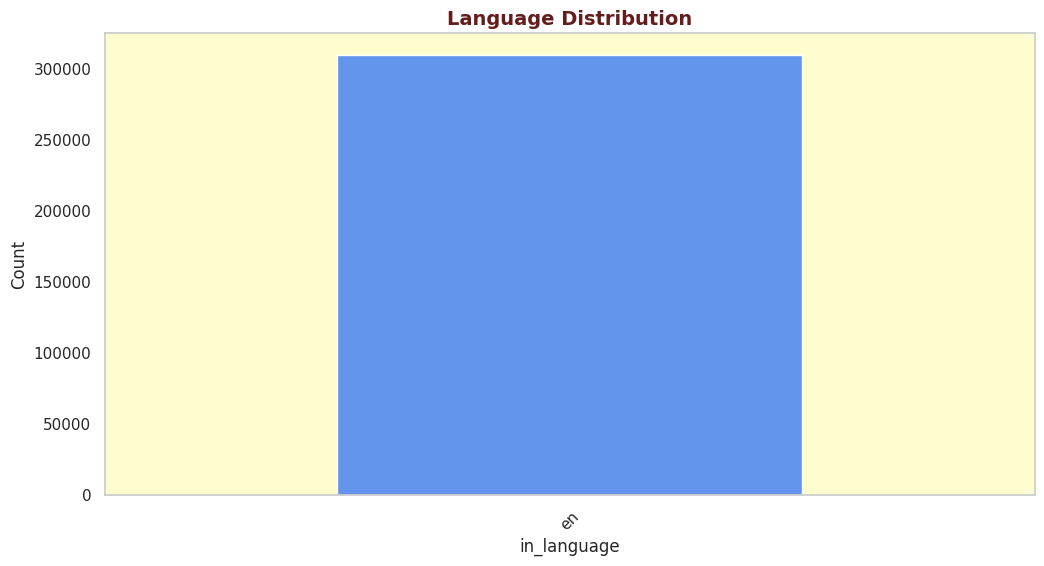

In [30]:
lang_counts = df['in_language'].dropna().apply(lambda x: x.get('identifier') if isinstance(x, dict) else x).value_counts()

lang_counts.plot(kind='bar', color='cornflowerblue')
plt.title('Language Distribution', fontsize=14, fontweight='bold', color='#641c1c')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.gca().set_facecolor('#fffdd0')
plt.grid(False)
plt.show()

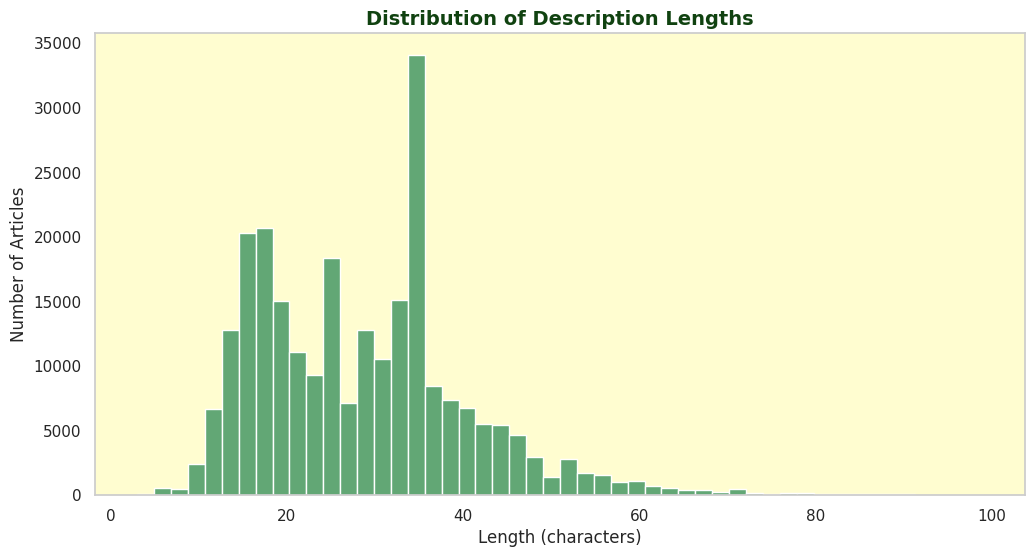

In [31]:
df['desc_length'] = df['description'].dropna().apply(lambda x: len(x))
sns.histplot(df['desc_length'], bins=50, color='seagreen')
plt.title("Distribution of Description Lengths", fontsize=14, fontweight='bold', color='#104210')
plt.xlabel("Length (characters)")
plt.ylabel("Number of Articles")
plt.gca().set_facecolor('#fffdd0')
plt.grid(False)
plt.show()

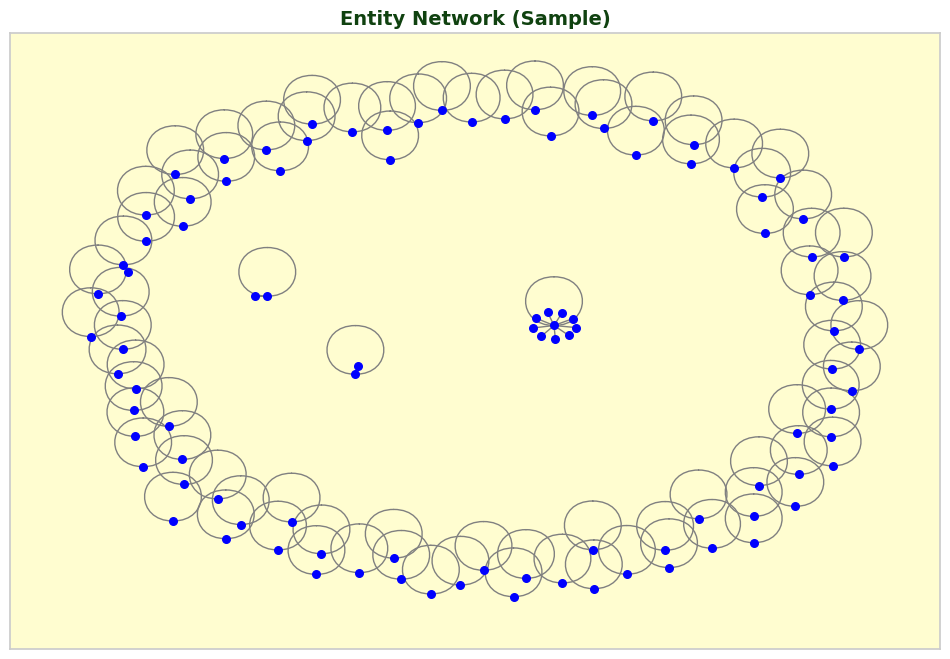

In [32]:
edges = []
for idx, row in df.dropna(subset=['main_entity', 'additional_entities']).iterrows():
    main = row['main_entity'].get('identifier') if isinstance(row['main_entity'], dict) else None
    others = [e.get('identifier') for e in row['additional_entities']] if isinstance(row['additional_entities'], list) else []
    for o in others:
        edges.append((main, o))

G = nx.Graph()
G.add_edges_from(edges[:100])  # for visualization, only 100 connections

plt.figure(figsize=(12, 8))
nx.draw_networkx(G, with_labels=False, node_size=30, edge_color='gray', node_color='blue')
plt.title("Entity Network (Sample)", fontsize=14, fontweight='bold', color='#104210')
plt.gca().set_facecolor('#fffdd0')
plt.grid(False)
plt.show()

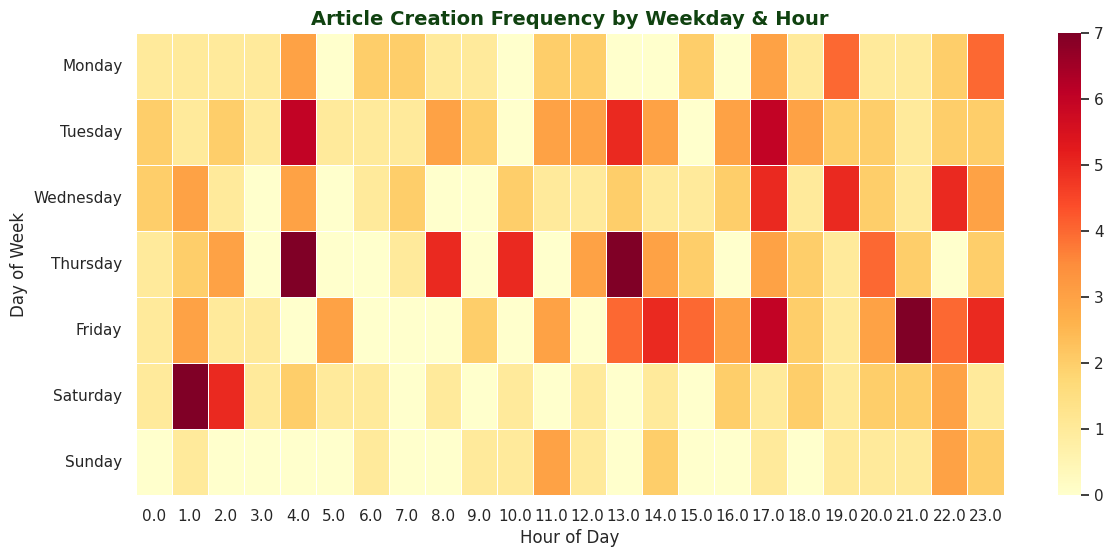

In [33]:
df['hour'] = df['date_created'].dt.hour
df['weekday'] = df['date_created'].dt.day_name()

heatmap_data = df.dropna(subset=['hour', 'weekday']).groupby(['weekday', 'hour']).size().unstack().fillna(0)
# Order weekdays
heatmap_data = heatmap_data.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

plt.figure(figsize=(14, 6))
sns.heatmap(heatmap_data, cmap="YlOrRd", linewidths=.5)
plt.title('Article Creation Frequency by Weekday & Hour', fontsize=14, fontweight='bold', color='#104210')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.show()

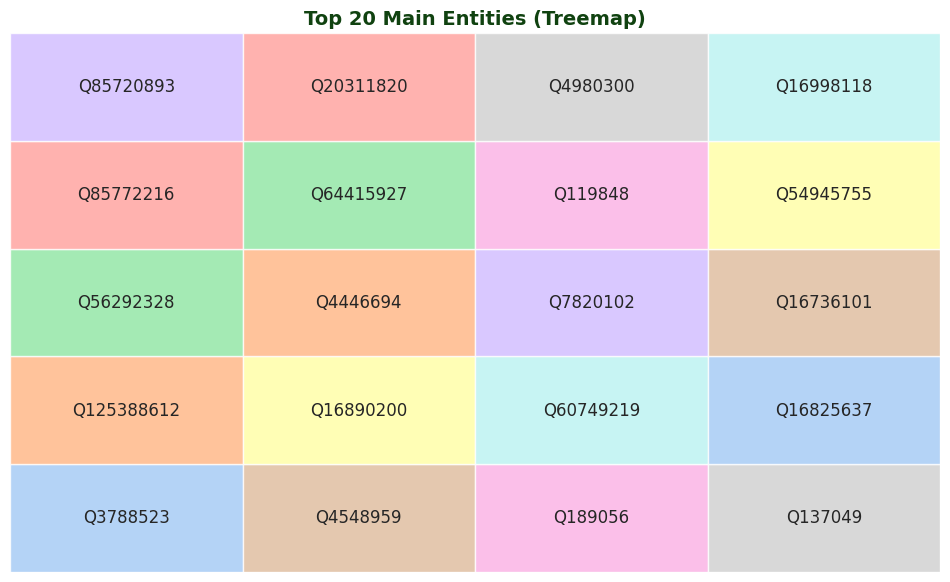

In [34]:
import squarify

main_entities = df['main_entity'].dropna().apply(lambda x: x['identifier'] if isinstance(x, dict) else None)
top_entities = main_entities.value_counts().head(20)

plt.figure(figsize=(12, 7))
squarify.plot(sizes=top_entities.values, label=top_entities.index, alpha=0.8, color=sns.color_palette('pastel'))
plt.title("Top 20 Main Entities (Treemap)", fontsize=14, fontweight='bold', color='#104210')
plt.axis('off')
plt.show()

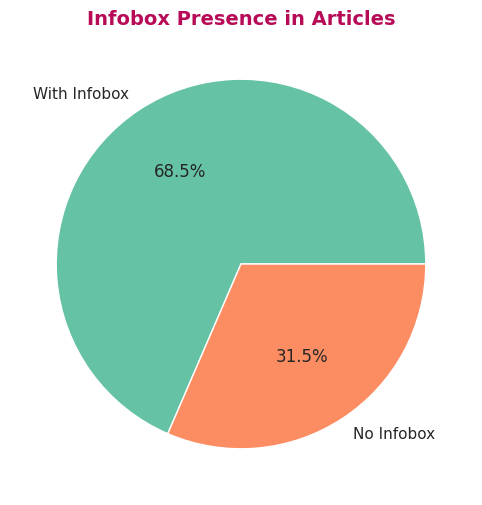

In [35]:
has_infobox = df['infoboxes'].notna().value_counts()
plt.figure()
has_infobox.plot(kind='pie', labels=['With Infobox', 'No Infobox'], autopct='%1.1f%%', colors=['#66c2a5','#fc8d62'])
plt.title("Infobox Presence in Articles", fontsize=14, fontweight='bold', color='#b80b57')
plt.ylabel('')
plt.show()

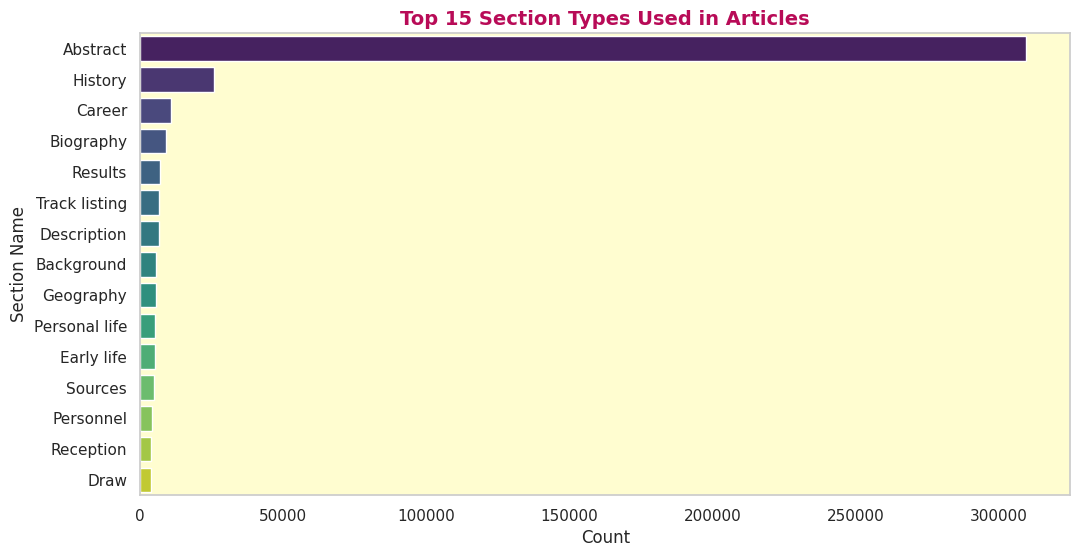

In [36]:
section_types = df['sections'].dropna().explode().apply(lambda x: x.get('name') if isinstance(x, dict) else None)
top_sections = section_types.value_counts().head(15)

sns.barplot(x=top_sections.values, y=top_sections.index, palette="viridis")
plt.title("Top 15 Section Types Used in Articles", fontsize=14, fontweight='bold', color='#b80b57')
plt.xlabel("Count")
plt.ylabel("Section Name")
plt.gca().set_facecolor('#fffdd0')
plt.grid(False)
plt.show()

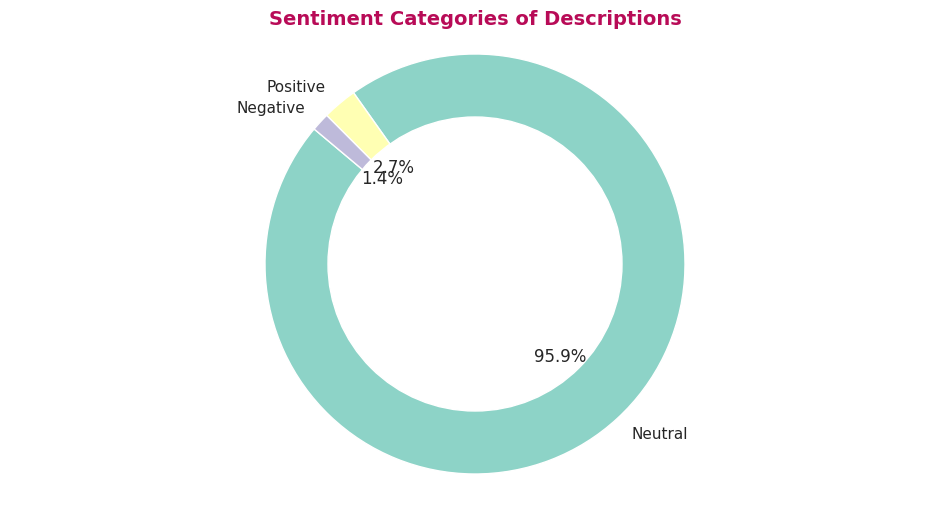

In [37]:
def sentiment_category(p):
    if p > 0.1:
        return 'Positive'
    elif p < -0.1:
        return 'Negative'
    else:
        return 'Neutral'

sent_cat = df['description'].dropna().apply(lambda x: sentiment_category(TextBlob(x).sentiment.polarity))
counts = sent_cat.value_counts()

# Donut chart
plt.figure()
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('Set3'))
centre_circle = plt.Circle((0,0),0.70,fc='white')
plt.gca().add_artist(centre_circle)
plt.title('Sentiment Categories of Descriptions', fontsize=14, fontweight='bold', color='#b80b57')
plt.axis('equal')
plt.show()

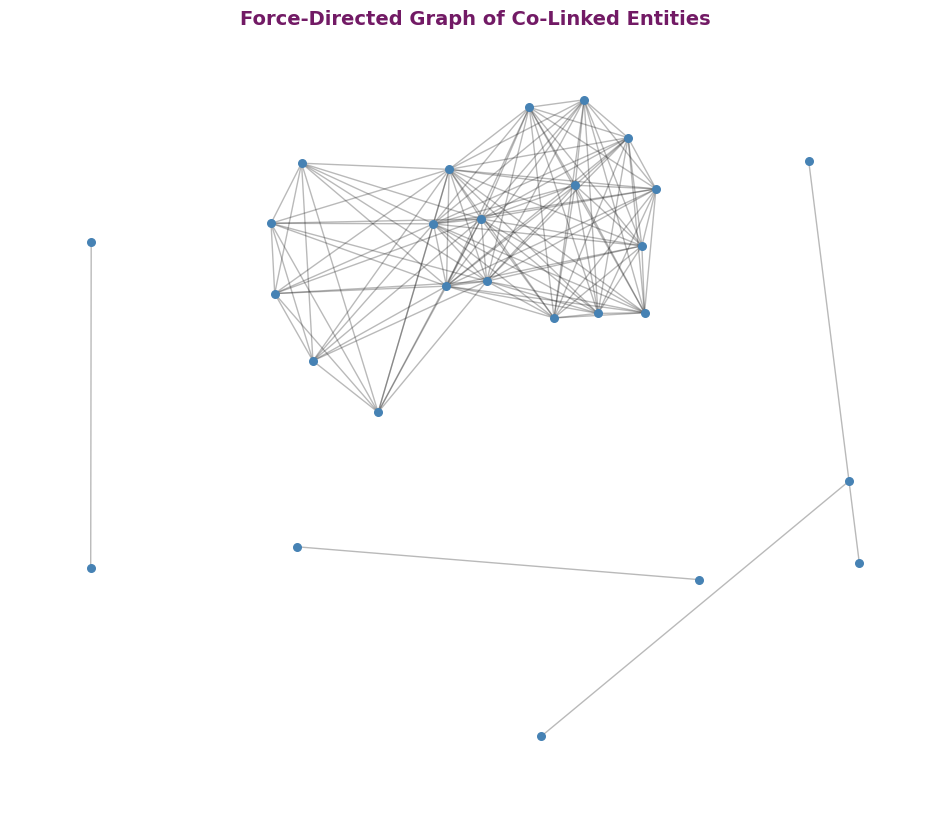

In [38]:
from itertools import combinations

G = nx.Graph()
for _, row in df.dropna(subset=['additional_entities']).head(200).iterrows():
    entities = [e['identifier'] for e in row['additional_entities'] if 'identifier' in e]
    for a, b in combinations(entities, 2):
        G.add_edge(a, b)

plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G, k=0.5, iterations=20)
nx.draw_networkx_nodes(G, pos, node_size=30, node_color='steelblue')
nx.draw_networkx_edges(G, pos, alpha=0.3)
plt.title("Force-Directed Graph of Co-Linked Entities", fontsize=14, fontweight='bold', color='#721a65')
plt.axis('off')
plt.show()

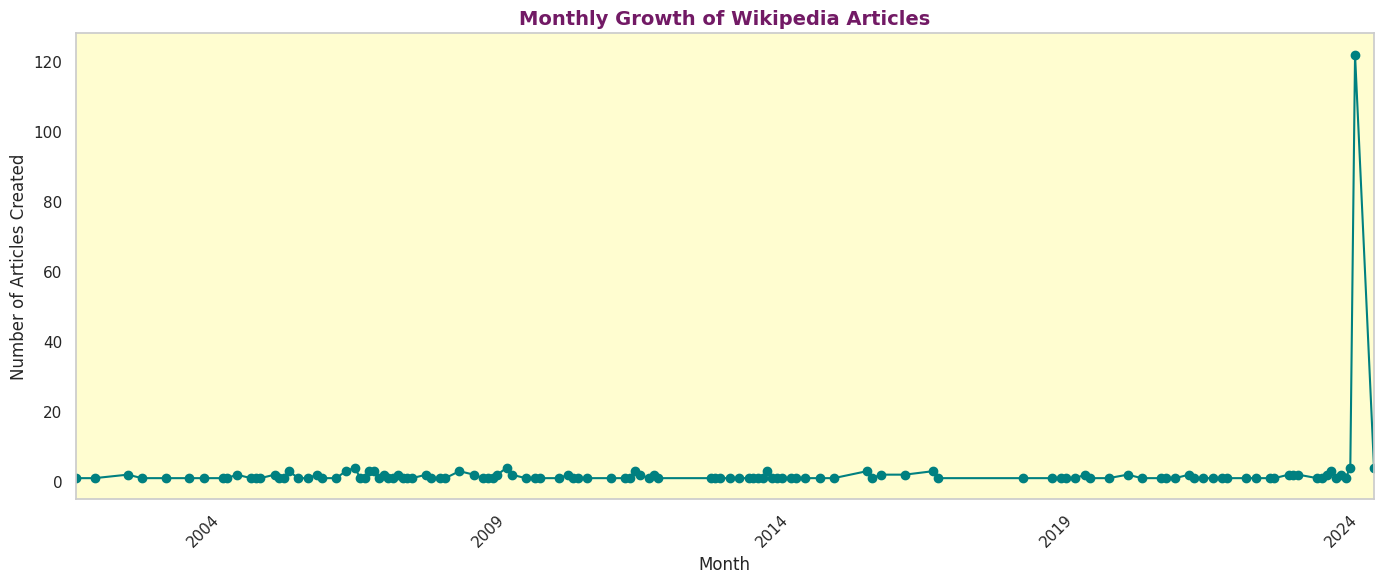

In [39]:
df['month_created'] = df['date_created'].dt.to_period('M')
monthly_growth = df.dropna(subset=['month_created']).groupby('month_created').size()

plt.figure(figsize=(14, 6))
monthly_growth.plot(kind='line', marker='o', color='teal')
plt.title('Monthly Growth of Wikipedia Articles', fontsize=14, fontweight='bold', color='#721a65')
plt.xlabel('Month')
plt.ylabel('Number of Articles Created')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.gca().set_facecolor('#fffdd0')
plt.grid(False)
plt.show()

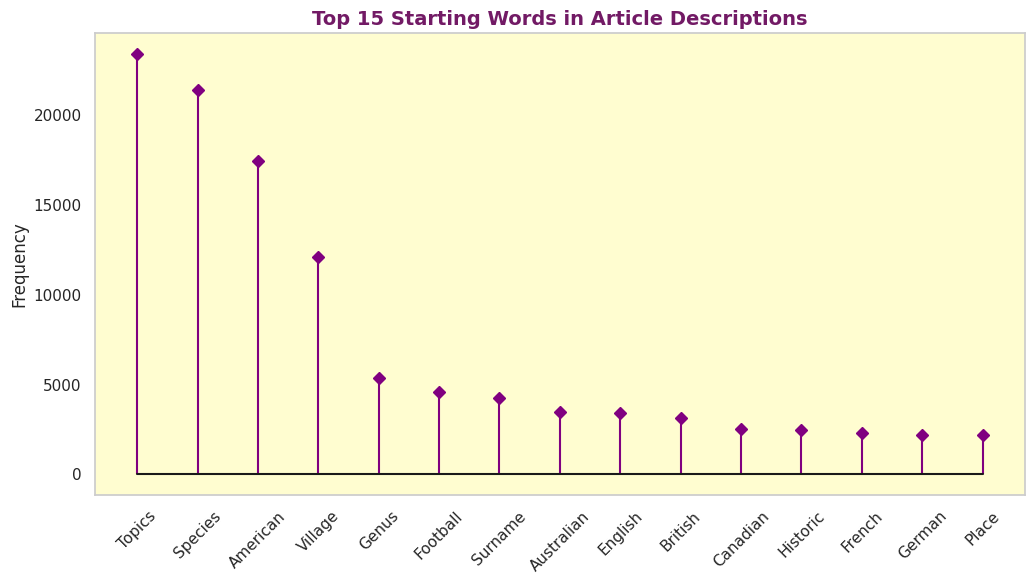

In [40]:
abstract_starts = df['description'].dropna().apply(lambda x: x.split()[0] if len(x.split()) > 0 else None)
top_starts = abstract_starts.value_counts().head(15)

plt.figure(figsize=(12, 6))
plt.stem(top_starts.index, top_starts.values, linefmt='purple', markerfmt='D', basefmt='k')
plt.title("Top 15 Starting Words in Article Descriptions", fontsize=14, fontweight='bold', color='#721a65')
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.gca().set_facecolor('#fffdd0')
plt.grid(False)
plt.show()

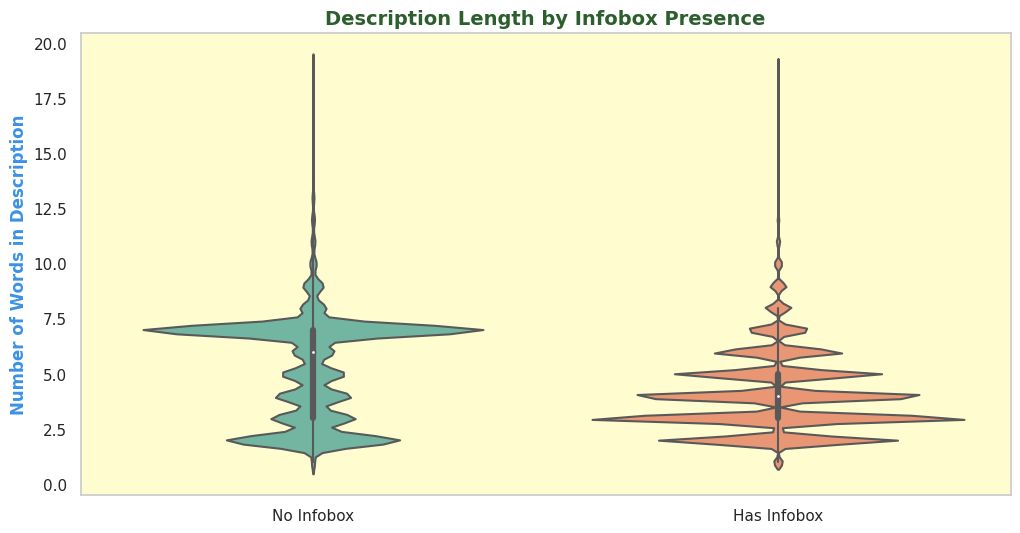

In [41]:
df['description_length'] = df['description'].dropna().apply(lambda x: len(x.split()))
df['has_infobox'] = df['infoboxes'].notna()

sns.violinplot(data=df.dropna(subset=['description_length']), x='has_infobox', y='description_length', palette='Set2')
plt.title("Description Length by Infobox Presence", fontsize=14, fontweight='bold', color='#2c5f2d')
plt.xticks([0, 1], ['No Infobox', 'Has Infobox'])
plt.xlabel('')
plt.ylabel('Number of Words in Description', fontsize=12, fontweight='bold', color='#3c91e6')
plt.gca().set_facecolor('#fffdd0')
plt.grid(False)
plt.show()

## English



In [42]:
pip install faiss-cpu sentence-transformers transformers openai

Note: you may need to restart the kernel to use updated packages.


In [43]:
import json
import pandas as pd
from tqdm import tqdm
import faiss
from sentence_transformers import SentenceTransformer
from transformers import pipeline, set_seed
import numpy as np

import warnings
warnings.filterwarnings("ignore")

2025-07-16 07:46:23.420830: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752651983.766321      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752651983.864529      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### === Step 1: Load and preprocess data ===

In [44]:
def read_jsonl(file_path, max_records=None):
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for i, line in enumerate(tqdm(f, desc="Reading JSONL")):
            if max_records and i >= max_records:
                break
            data.append(json.loads(line))
    return data

file_path = "/kaggle/input/wikipedia-structured-contents/enwiki_namespace_0/enwiki_namespace_0_0.jsonl"
raw_data = read_jsonl(file_path, max_records=10000)
df = pd.DataFrame(raw_data)

Reading JSONL: 10000it [00:01, 8878.73it/s]


### === Step 2: Build corpus ===

In [45]:
def build_text(row):
    text = ''
    if isinstance(row.get('description'), str):
        text += row['description'] + "\n"
    if isinstance(row.get('abstract'), str):
        text += row['abstract'] + "\n"
    if isinstance(row.get('sections'), list):
        for sec in row['sections']:
            if 'text' in sec:
                text += sec['text'] + "\n"
    return text.strip()

df['text'] = df.apply(build_text, axis=1)
df = df[df['text'].str.len() > 50].reset_index(drop=True)

corpus = df['text'].tolist()
titles = df['name'].tolist()

### === Step 3: Embed and index with FAISS ===

In [46]:
model = SentenceTransformer("all-MiniLM-L6-v2")

embeddings = model.encode(corpus, show_progress_bar=True)

index = faiss.IndexFlatL2(embeddings.shape[1])

index.add(np.array(embeddings))

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/310 [00:00<?, ?it/s]

### === Step 4: RAG Retrieval + Generation ===

In [47]:
def retrieve(query, k=5):
    q_embedding = model.encode([query])
    D, I = index.search(q_embedding, k)
    return [(titles[i], corpus[i]) for i in I[0]]

qa_pipeline = pipeline("text-generation", model="gpt2")
set_seed(42)


def generate_answer(query, top_k=5, max_new_tokens=100):
    docs = retrieve(query, k=top_k)
    context = "\n---\n".join([f"{i+1}. {doc[1]}" for i, doc in enumerate(docs)])
    prompt = f"Answer the following question using the context below:\n\nContext:\n{context}\n\nQuestion: {query}\nAnswer:"
    
    response = qa_pipeline(
        prompt,
        max_new_tokens=max_new_tokens,
        do_sample=True,
        top_k=50,
        pad_token_id=50256,
        truncation=True  # Optional, just to silence tokenizer warnings
    )
    return response[0]['generated_text'].split("Answer:")[-1].strip()

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0


### === Step 5: Ask a question! ===

In [48]:
query = "What is the Second Polish Republic?"
answer = generate_answer(query)
print("\n📌 Query:", query)
print("\n💡 Answer:", answer)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


📌 Query: What is the Second Polish Republic?

💡 Answer: The Second Polish Republic is a modern, highly industrialized nation with some 5 million citizens and about 100% foreign trade.

---

6. The Polish people, like everyone else, have a great longing for a better future for Poland.

According to the Polish press, the Second Polish Republic is a "national project" and that the Polish people are "satisfied" in the end with the development of their country and are ready to "join" the future of their country.


In [49]:
query = "What are the main causes of the French Revolution?"
answer = generate_answer(query)
print("\n📌 Query:", query)
print("\n💡 Answer:", answer)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


📌 Query: What are the main causes of the French Revolution?

💡 Answer: The cause of the French Revolution is the economic system. The French Revolution was a social revolution initiated in spite of the fact that capital was divided into two classes: the bourgeoisie and the poor. This system of economic management was used to develop the social classes and the peasants were forced to work to the ends they were required to.

The following is a history of the French Revolution:

1. The French Revolution

2. The Armagnac Revolution

3. The French Revolution


In [50]:
query = "Who discovered penicillin and how did it change medicine?"
answer = generate_answer(query)
print("\n📌 Query:", query)
print("\n💡 Answer:", answer)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


📌 Query: Who discovered penicillin and how did it change medicine?

💡 Answer: We have to admit that we do not know. We know that the penicillin, once a common medicine in Europe, became a popular and widespread medicine in the Mediterranean, where it was used in the 1st century AD. It was used in the 1st century AD as an anti-inflammatory and a cure for leprosy.

---

6. Ancient Greek surgeon
The Greek surgeon is known from the beginning of the 6th century AD, when he was called Hæ


In [51]:
query = "..."
answer = generate_answer(query)
print("\n📌 Query:", query)
print("\n💡 Answer:", answer)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


📌 Query: ...

💡 Answer: 7. Greek word for God
I am a Greek word for God and this is a bit difficult to explain.

---

8. In-flight navigation systems

The following is a recent example of a flight using flight management systems:

---

9. The Sky

The Sky is a small, flat black object that appears as a bright rainbow, and it is the only object on Earth that can travel at more than half the speed of light.


## French

In [52]:
import json
import pandas as pd
from tqdm import tqdm
import faiss
from sentence_transformers import SentenceTransformer
from transformers import pipeline, set_seed
import numpy as np

import warnings
warnings.filterwarnings("ignore")



### === Step 1: Load and preprocess data ===

In [60]:
def read_jsonl(file_path, max_records=None):
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for i, line in enumerate(tqdm(f, desc="Reading JSONL")):
            if max_records and i >= max_records:
                break
            data.append(json.loads(line))
    return data

file_path = "/kaggle/input/wikipedia-structured-contents/frwiki_namespace_0/frwiki_namespace_0_1.jsonl"
raw_data = read_jsonl(file_path, max_records=10000)
df = pd.DataFrame(raw_data)

Reading JSONL: 10000it [00:01, 7149.86it/s]


### === Step 2: Build corpus ===

In [61]:
def clean_text(text):
    text = re.sub(r'\s+', ' ', text)  # Remove excessive whitespace
    return text.strip()


def flatten_text(value):
    """Transforme récursivement listes et dictionnaires en chaînes de texte plates."""
    if isinstance(value, str):
        return value
    elif isinstance(value, list):
        return " ".join(flatten_text(item) for item in value if item)
    elif isinstance(value, dict):
        return " ".join(flatten_text(v) for v in value.values() if v)
    else:
        return ""

def build_text(row):
    parts = []
    for field in ['description', 'abstract']:
        val = row.get(field)
        if val:
            parts.append(flatten_text(val))

    if isinstance(row.get('sections'), list):
        for sec in row['sections']:
            if isinstance(sec, dict) and 'text' in sec:
                parts.append(flatten_text(sec['text']))
    
    return clean_text("\n".join(parts))

df['text'] = df.apply(build_text, axis=1)
df = df[df['text'].str.len() > 100].reset_index(drop=True)

corpus = df['text'].tolist()
titles = df['name'].tolist()

### === Step 3: Embed and index with FAISS ===

In [62]:
model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = model.encode(corpus, show_progress_bar=True, normalize_embeddings=True)

index = faiss.IndexFlatIP(embeddings.shape[1])
index.add(np.array(embeddings))

Batches:   0%|          | 0/276 [00:00<?, ?it/s]

### === Step 4: RAG Retrieval + Generation ===

In [63]:
def retrieve(query, k=5):
    q_embedding = model.encode([query], normalize_embeddings=True)
    D, I = index.search(q_embedding, k)
    return [(titles[i], corpus[i]) for i in I[0] if i < len(corpus)]

qa_pipeline = pipeline("text2text-generation", model="google/flan-t5-base", tokenizer="google/flan-t5-base")
set_seed(42)

def generate_answer(query, top_k=5, max_new_tokens=200):
    docs = retrieve(query, k=top_k)

    if not docs:
        return "Aucune information pertinente trouvée pour répondre à cette question."
        
    context = "\n\n".join([f"[{i+1}] {doc[1][:1000]}" for i, doc in enumerate(docs)])
    
    prompt = (
        f"Voici des extraits de documents Wikipedia :\n\n{context}\n\n"
        f"Question : {query}\n"
        f"Réponse :"
)
    
    response = qa_pipeline(
        prompt,
        max_new_tokens=max_new_tokens,
        do_sample=True,
        top_k=50,
        temperature=0.7,
        pad_token_id=qa_pipeline.tokenizer.eos_token_id,
        truncation=True  # Optional, just to silence tokenizer warnings
    )
    generated = response[0]['generated_text']
    return generated.split("Réponse :")[-1].strip()

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

Device set to use cuda:0


### === Step 5: Ask a question! ===

In [64]:
query = "Qu'est-ce que la Deuxième République polonaise ?"
answer = generate_answer(query)
print("\n📌 Query:", query)
print("\n💡 Answer:", answer)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


📌 Query: Qu'est-ce que la Deuxième République polonaise ?

💡 Answer: [2] physicienne polonaise Irena Sofia Romaszewska ou Zofia Romaszewska, née Irena Sofia Ploska le 17 août 1940, à Varsovie, est une militante polonaise, membre de l'opposition démocratique à l'époque de la République populaire de Pologne. Elle a été notamment un présentatrice de Radio-Solidarité. Elle est aujourd'hui social conseillère du président de la République de Pologne. Elle s'est vu décerner l'Ordre de L'Aigle blanc. [3] ville polonaise Pakosze est un village polonaise de la vovodie de Varmie-Mazurie, dans le powiat de Braniewo. [4] ville polonaise


In [65]:
query = "Quelles sont les principales causes de la Révolution française ?"
answer = generate_answer(query)
print("\n📌 Query:", query)
print("\n💡 Answer:", answer)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


📌 Query: Quelles sont les principales causes de la Révolution française ?

💡 Answer: [3] personnalité politique Emmanuel Clairefond, né le 20 avril 1897 à Valence et mort le 21 novembre 1953 à Angers, est un homme politique français. [4] danseur et chorégraphe français Jean Guizerix, né le 27 octobre 1945 à Paris 6e, est un chorégraphe et danseur étoile français.


In [66]:
query = "Quelle est l'histoire de la Tour Eiffel et pourquoi est-elle célèbre ?"
answer = generate_answer(query)

print("\n📌 Question:", query)
print("\n💡 Réponse:", answer)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


📌 Question: Quelle est l'histoire de la Tour Eiffel et pourquoi est-elle célèbre ?

💡 Réponse: [1] Le Tour de Catalogne 1935 est la 17e édition du Tour de Catalogne, une course cycliste par étapes en Espagne. L'épreuve se déroule sur nou étapes entre l'1 et le 9 juin 1935, sur un total de 1 358 km. Le vainqueur final est l'Espagnol Mariano Caardo, devant l'Espagnol Federico Ezquerra et le Belge Joseph Huts. [2] église située dans le Nord, en France L'église Saint-Pierre-à-Antioche est une église catholique située à Tourmignies, en France. [3] footballeur français Reynald Lemaître, né le 28 juin 1983 à Chambray-lès-Tours, est un footballeur français.


*******************************************************  
***As we constate, we do not get a better result for our RAG. So let's combine it with LangChain.***   
*******************************************************

## LangChain + RAG

Combiner le pipeline RAG avec LangChain nous permettrait d'avoir :

* une meilleure **gestion du contexte** (via `**Document**` et `**Retriever**`),

* une **chaîne modulaire et configurable** (retrieval, re-ranking, prompt, génération...),

* et une intégration fluide avec des **LLMs instruct finetunés** (OpenAI, Hugging Face, Mistral, etc.).


***Question → Embedding → FAISS (retriever) → Context → Prompt → LLM → Réponse cohérente***

In [74]:
!pip install langchain langchain-community

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 27.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 1.9 MB/s eta 0:00:00


* **Charger les données**

In [84]:
import os
import json
import pandas as pd
from tqdm import tqdm

def read_selected_jsonl_files(folder_path, file_names, max_records=None):
    data = []
    total_loaded = 0

    for file_name in file_names:
        file_path = os.path.join(folder_path, file_name)
        with open(file_path, 'r', encoding='utf-8') as f:
            for line in f:
                if max_records and total_loaded >= max_records:
                    break
                try:
                    data.append(json.loads(line))
                    total_loaded += 1
                except json.JSONDecodeError:
                    continue  # Ignore corrupted lines
        if max_records and total_loaded >= max_records:
            break

    return data

folder_path = "/kaggle/input/wikipedia-structured-contents/frwiki_namespace_0"
selected_files = ["frwiki_namespace_0_0.jsonl", "frwiki_namespace_0_1.jsonl", "frwiki_namespace_0_2.jsonl"]

raw_data = read_selected_jsonl_files(folder_path, selected_files, max_records=10000)
df = pd.DataFrame(raw_data)
df.head()

,name,identifier,abstract,version,event,url,date_created,date_modified,is_part_of,in_language,license,infoboxes,sections,main_entity,additional_entities,image,description
0,Esochí,16411141,Esochí est une localité située dans le dème d'...,"{'identifier': 217351334, 'comment': 'Nouvelle...",{'identifier': '4e7b5406-bab5-4f31-a440-2fd05d...,https://fr.wikipedia.org/wiki/Esoch%C3%AD,2024-08-03T20:57:38Z,2024-08-03T20:57:38Z,"{'identifier': 'frwiki', 'url': 'https://fr.wi...",{'identifier': 'fr'},[{'name': 'Creative Commons Attribution-ShareA...,"[{'type': 'infobox', 'name': 'Infobox Localité'}]","[{'type': 'section', 'name': 'Abstract', 'has_...",NaN,NaN,NaN,NaN
1,Néo Kallyndíri,16411154,Néo Kallyndíri est une localité située dans le...,"{'identifier': 217351536, 'comment': 'Nouvelle...",{'identifier': '85a1ab17-0b50-4e7b-97ff-3a3eaa...,https://fr.wikipedia.org/wiki/N%C3%A9o_Kallynd...,2024-08-03T21:05:44Z,2024-08-03T21:05:44Z,"{'identifier': 'frwiki', 'url': 'https://fr.wi...",{'identifier': 'fr'},[{'name': 'Creative Commons Attribution-ShareA...,"[{'type': 'infobox', 'name': 'Infobox Localité'}]","[{'type': 'section', 'name': 'Abstract', 'has_...",NaN,NaN,NaN,NaN
2,Manoir de Kergurion,16411607,Le manoir de Kergurion est un édifice situé à ...,"{'identifier': 217363058, 'comment': 'Nouvelle...",{'identifier': '3cbccf5d-30c8-4733-83ce-6ff3b0...,https://fr.wikipedia.org/wiki/Manoir_de_Kergurion,2024-08-04T09:21:32Z,2024-08-04T09:21:32Z,"{'identifier': 'frwiki', 'url': 'https://fr.wi...",{'identifier': 'fr'},[{'name': 'Creative Commons Attribution-ShareA...,"[{'type': 'infobox', 'name': 'Infobox Monument...","[{'type': 'section', 'name': 'Abstract', 'has_...",NaN,NaN,NaN,NaN
3,Lucienne Legrand (1920-2022),5439314,Lucienne Legrand est une actrice française née...,"{'identifier': 217371250, 'comment': 'Màj selo...",{'identifier': '7eaa802d-8761-4b55-a6bd-32ebdd...,https://fr.wikipedia.org/wiki/Lucienne_Legrand...,2011-04-23T14:45:40Z,2024-08-04T14:40:24Z,"{'identifier': 'frwiki', 'url': 'https://fr.wi...",{'identifier': 'fr'},[{'name': 'Creative Commons Attribution-ShareA...,"[{'type': 'infobox', 'name': 'Infobox Cinéma (...","[{'type': 'section', 'name': 'Abstract', 'has_...","{'identifier': 'Q1873439', 'url': 'https://www...","[{'identifier': 'P2019', 'url': 'https://www.w...",NaN,NaN
4,Histoire de l'industrie automobile à Reims,16412245,Reims a joué un rôle non négligeable dans l'hi...,"{'identifier': 217379705, 'comment': 'Ajour li...",{'identifier': '0384034b-d721-49fc-ba56-29dfb0...,https://fr.wikipedia.org/wiki/Histoire_de_l%27...,2024-08-04T17:04:02Z,2024-08-04T20:14:56Z,"{'identifier': 'frwiki', 'url': 'https://fr.wi...",{'identifier': 'fr'},[{'name': 'Creative Commons Attribution-ShareA...,NaN,"[{'type': 'section', 'name': 'Abstract', 'has_...",NaN,NaN,NaN,NaN


* **Build Corpus**

In [85]:
def clean_text(text):
    text = re.sub(r'\s+', ' ', text)  # Remove excessive whitespace
    return text.strip()


def flatten_text(value):
    """Transforme récursivement listes et dictionnaires en chaînes de texte plates."""
    if isinstance(value, str):
        return value
    elif isinstance(value, list):
        return " ".join(flatten_text(item) for item in value if item)
    elif isinstance(value, dict):
        return " ".join(flatten_text(v) for v in value.values() if v)
    else:
        return ""

def build_text(row):
    parts = []
    for field in ['description', 'abstract']:
        val = row.get(field)
        if val:
            parts.append(flatten_text(val))

    if isinstance(row.get('sections'), list):
        for sec in row['sections']:
            if isinstance(sec, dict) and 'text' in sec:
                parts.append(flatten_text(sec['text']))
    
    return clean_text("\n".join(parts))

df['text'] = df.apply(build_text, axis=1)
df = df[df['text'].str.len() > 100].reset_index(drop=True)

corpus = df['text'].tolist()
titles = df['name'].tolist()

### === Créer les Document + VectorStore FAISS ===

In [88]:
from langchain.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.docstore.document import Document

* **Step 1 : Transformer ton corpus en objets Document**  

In [89]:
documents = [Document(page_content=text, metadata={"title": titles[i]}) for i, text in enumerate(corpus)]


* **Step 2 : Embeddings + FAISS index**

In [90]:
embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
vectorstore = FAISS.from_documents(documents, embedding_model)

* **Step 3: Définir un Retriever**

In [91]:
retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 5})

* **Step 4: Définir le modèle LLM de génération**

In [92]:
from langchain.llms import HuggingFacePipeline
from transformers import pipeline

# LLM instruct (ici Flan-T5)
llm_pipeline = pipeline("text2text-generation", model="google/flan-t5-base")
llm = HuggingFacePipeline(pipeline=llm_pipeline)


Device set to use cuda:0


* **Stpe 5: Créer la chaîne RAG avec LangChain**

In [93]:
from langchain.chains import RetrievalQA

qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    retriever=retriever,
    chain_type="stuff",  # Concatène tous les documents dans le prompt
    return_source_documents=True
)


* **Step 6: Interroger la chaîne RAG**

In [94]:
query = "Qu'est-ce que la Deuxième République polonaise ?"
result = qa_chain(query)

print("\n📌 Question :", query)
print("\n💡 Réponse :", result['result'])


📌 Question : Qu'est-ce que la Deuxième République polonaise ?

💡 Réponse : st nad Labem, en République tchèque.


In [95]:
# Si tu veux voir les documents utilisés :
for i, doc in enumerate(result["source_documents"]):
    print(f"\n📄 Doc {i+1} (titre: {doc.metadata['title']}):\n{doc.page_content[:300]}...")



📄 Doc 1 (titre: Ardapy):
ville polonaise Ardapy est un village polonais de la voïvodie de Varmie-Mazurie, dans le powiat de Bartoszyce....

📄 Doc 2 (titre: Czesław Niemen):
auteur compositeur interprète de rock polonais Czesław Juliusz Niemen, né le 16 février 1939 à Stare Wasiliszki (en) et mort d'un cancer le 17 janvier 2004 à Varsovie, est un chanteur polonais. Proclamé « chanteur polonais du XXe siècle » à l’issue d’un plébiscite organisé par le journal Polityka, i...

📄 Doc 3 (titre: Damien Perquis (football, 1984)):
footballeur polonais et français Damien Perquis, né le 10 avril 1984 à Troyes en France, est un footballeur international polonais qui évolue durant sa carrière au poste de défenseur....

📄 Doc 4 (titre: Bodo Kox):
acteur polonais Bodo Kox, de son vrai nom, Bartosz Koszała est un réalisateur et scénariste polonais, né le 22 avril 1977 à Wrocław....

📄 Doc 5 (titre: Championnats d'Europe de pentathlon moderne 2002):
Les Championnats d'Europe de pentathlon moderne 2002

In [70]:
from transformers import pipeline
from sentence_transformers import SentenceTransformer
import faiss
import numpy as np

# Embedding model
embedder = SentenceTransformer("all-MiniLM-L6-v2")

# Corpus (déjà extrait dans ton notebook)
corpus_embeddings = embedder.encode(corpus, show_progress_bar=True, normalize_embeddings=True)
dimension = corpus_embeddings.shape[1]
index = faiss.IndexFlatIP(dimension)
index.add(np.array(corpus_embeddings))

# QA model — très bon pour répondre dans un style cohérent
qa_pipeline = pipeline("text2text-generation", model="google/flan-t5-base", tokenizer="google/flan-t5-base")

def retrieve(query, k=5):
    q_embedding = embedder.encode([query], normalize_embeddings=True)
    D, I = index.search(q_embedding, k)
    return [corpus[i] for i in I[0] if i < len(corpus)]

def generate_answer(query, top_k=5, max_new_tokens=256):
    docs = retrieve(query, k=top_k)
    context = "\n".join(docs)
    prompt = f"Réponds à la question suivante en t'appuyant sur le contexte ci-dessous :\n\nContexte : {context}\n\nQuestion : {query}\nRéponse :"

    response = qa_pipeline(
        prompt,
        max_new_tokens=max_new_tokens,
        do_sample=False  # On désactive l'aléatoire ici
    )

    return response[0]['generated_text'].strip()

# Exemple de question
query = "Qu'est-ce que la Deuxième République polonaise ?"
answer = generate_answer(query)

print("\n📌 Question :", query)
print("\n💡 Réponse :", answer)


Batches:   0%|          | 0/276 [00:00<?, ?it/s]

Device set to use cuda:0


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


📌 Question : Qu'est-ce que la Deuxième République polonaise ?

💡 Réponse : La Deuxième République polonaise a fait l'objet d'une politique démocratique à l'époque de la République populaire de Pologne. Elle a été notamment une présentatrice de Radio-Solidarité. Elle est aujourd'hui conseillère sociale du président de la République de Pologne. Elle s'est vu décerner l'Ordre de L'Aigle blanc.


In [107]:
import os
import gradio as gr
import json
from langchain.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.docstore.document import Document
from langchain.chains import RetrievalQA
from langchain.llms import HuggingFacePipeline
from transformers import pipeline
from tqdm import tqdm

# === Load JSONL data ===
def read_jsonl_files(file_paths, max_records=None):
    data = []
    total = 0
    for path in file_paths:
        with open(path, 'r', encoding='utf-8') as f:
            for line in f:
                if max_records and total >= max_records:
                    return data
                try:
                    data.append(json.loads(line))
                    total += 1
                except json.JSONDecodeError:
                    continue
    return data

# === Build corpus ===
def build_text(row):
    parts = []
    if isinstance(row.get('description'), str):
        parts.append(row['description'])
    if isinstance(row.get('abstract'), str):
        parts.append(row['abstract'])
    if isinstance(row.get('sections'), list):
        for sec in row['sections']:
            if isinstance(sec, dict) and 'text' in sec:
                parts.append(sec['text'])
    return "\n".join(parts).strip()

# === Load and process data ===
file_paths = [
    "/kaggle/input/wikipedia-structured-contents/frwiki_namespace_0/frwiki_namespace_0_0.jsonl",  # mets ici tes fichiers
    "/kaggle/input/wikipedia-structured-contents/frwiki_namespace_0/frwiki_namespace_0_1.jsonl",
    "/kaggle/input/wikipedia-structured-contents/frwiki_namespace_0/frwiki_namespace_0_2.jsonl"
]
raw_data = read_jsonl_files(file_paths, max_records=10000)
documents = []

for row in tqdm(raw_data):
    text = build_text(row)
    if len(text) > 100:
        title = row.get("name", "Sans titre")
        documents.append(Document(page_content=text, metadata={"title": title}))

# === Embedding + FAISS ===
embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
vectorstore = FAISS.from_documents(documents, embedding_model)
retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 5})

# === Load LLM (Mistral Instruct) ===
llm_pipeline = pipeline(
    "text2text-generation",
    model="google/flan-t5-base",
    tokenizer="google/flan-t5-base",
    device_map="auto",
    max_new_tokens=512,
    temperature=0.7,
    top_k=50
)
llm = HuggingFacePipeline(pipeline=llm_pipeline)

# === RAG Chain ===
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    retriever=retriever,
    chain_type="stuff",
    return_source_documents=True
)

# === Gradio Interface ===
def answer_question(question):
    result = qa_chain(question)
    answer = result['result']
    sources = "\n".join([f"- {doc.metadata['title']}" for doc in result['source_documents']])
    return f"💬 **Réponse :**\n{answer}\n\n📚 **Sources :**\n{sources}"

gr.Interface(
    fn=answer_question,
    inputs=gr.Textbox(label="Posez votre question"),
    outputs=gr.Markdown(label="Réponse"),
    title="📘 Wikipedia QA avec LangChain + Mistral",
    description="Posez une question sur les articles Wikipedia (corpus filtré)."
).launch()


100%|██████████| 10000/10000 [00:00<00:00, 170941.41it/s]
Device set to use cuda:0
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


* Running on local URL:  http://127.0.0.1:7866
It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

* Running on public URL: https://1a69db932a8469a170.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [99]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 5.0 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.5.1
    Uninstalling fsspec-2025.5.1:
      Successfully uninstalled fsspec-2025.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
bigframes 2.8.0 requires google-cloud-bigquery[bqstorage,pandas]>=3.31.0, but you have google-cloud-bigquery 3.25.0 which is incompatible.
bigframes 2.8.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.


In [111]:
import os
import gradio as gr
from datasets import load_dataset
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_core.documents import Document
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate
from langchain.llms import HuggingFacePipeline
from transformers import pipeline, AutoTokenizer, AutoModelForSeq2SeqLM
from tqdm import tqdm

# ----------- 📚 Charger et tronquer Wikipedia -----------

def load_wikipedia_dataset(lang="fr", max_docs=3000, max_chars=800):
    dataset = load_dataset("wikipedia", f"20220301.{lang}", split="train")
    docs = []
    for row in tqdm(dataset.select(range(max_docs)), desc="📚 Chargement Wikipedia"):
        text = row["text"].strip()
        if len(text) > 50:
            truncated = text[:max_chars]
            docs.append(Document(page_content=truncated, metadata={"title": row["title"]}))
    return docs

documents = load_wikipedia_dataset()

# ----------- 🧠 Embeddings et FAISS -----------

embedding_model = "sentence-transformers/all-MiniLM-L6-v2"
embeddings = HuggingFaceEmbeddings(model_name=embedding_model)
vectorstore = FAISS.from_documents(documents, embeddings)
retriever = vectorstore.as_retriever(search_kwargs={"k": 5})

# ----------- 🤖 Modèle Flan-T5 -----------

model_name = "google/flan-t5-xl"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

pipe = pipeline("text2text-generation", model=model, tokenizer=tokenizer, max_new_tokens=256)
llm = HuggingFacePipeline(pipeline=pipe)

# ----------- 🔗 Prompt compact et RetrievalQA -----------

prompt = PromptTemplate(
    input_variables=["context", "question"],
    template="""
Tu es un assistant intelligent francophone. Réponds uniquement à partir du CONTEXTE donné.
Si la réponse n’est pas dans le contexte, dis simplement : "Je ne sais pas".

Contexte : {context}
Question : {question}
Réponse :
"""
)

qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    retriever=retriever,
    chain_type="stuff",
    chain_type_kwargs={"prompt": prompt},
    return_source_documents=False,
)

# ----------- 💬 Interface Gradio -----------

def chatbot_response(question, max_tokens, temperature):
    pipe.model.config.max_new_tokens = int(max_tokens)
    pipe.model.config.temperature = float(temperature)
    result = qa_chain.run(question)
    return result.strip()

interface = gr.Interface(
    fn=chatbot_response,
    inputs=[
        gr.Textbox(label="Ta question sur Wikipedia", placeholder="Ex : Qui est Molière ?"),
        gr.Slider(label="Max Tokens", minimum=10, maximum=512, value=256, step=1),
        gr.Slider(label="Température", minimum=0.1, maximum=1.0, value=0.7, step=0.01)
    ],
    outputs=gr.Textbox(label="Réponse"),
    title="📚 Wikipedia RAG Chatbot",
    description="Pose une question, la réponse sera générée à partir d’un extrait du Wikipedia français (résumés seulement)."
)

interface.launch(share=True)


📚 Chargement Wikipedia: 100%|██████████| 3000/3000 [00:00<00:00, 10012.64it/s]


tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.45G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Device set to use cuda:0


* Running on local URL:  http://127.0.0.1:7869
* Running on public URL: https://52126d6a45143ab8d5.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Token indices sequence length is longer than the specified maximum sequence length for this model (1330 > 512). Running this sequence through the model will result in indexing errors
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/gradio/queueing.py", line 625, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/gradio/route_utils.py", line 322, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/gradio/blocks.py", line 2191, in process_api
    result = await self.call_function(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/gradio/blocks.py", line 1702, in call_function
    prediction = await anyio.to_thread.run_sync(  # type: ignore
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

In [115]:
pip install -U langchain langchain-community langchain-huggingface


Note: you may need to restart the kernel to use updated packages.


In [127]:
from datasets import load_dataset
from langchain_community.vectorstores import FAISS
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain.chains import RetrievalQA
from langchain_community.llms import HuggingFacePipeline
from transformers import pipeline, AutoTokenizer, AutoModelForSeq2SeqLM
from langchain.docstore.document import Document
import gradio as gr

# 1. Charger un sous-ensemble réduit du dataset Wikipedia français (ex: 100 articles)
def load_wikipedia_subset(n_articles=100):
    dataset = load_dataset("wikimedia/wikipedia", "20231101.fr", split="train")
    subset = dataset.select(range(n_articles))
    docs = []
    for sample in subset:
        text = sample.get("text") or sample.get("summary")
        if text:
            docs.append(Document(page_content=text))
    return docs

# 2. Découper les documents
def split_docs(docs):
    splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
    return splitter.split_documents(docs)

# 3. Créer une base vectorielle FAISS avec embeddings HuggingFace
def create_vectorstore(splitted_docs):
    embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")
    vectorstore = FAISS.from_documents(splitted_docs, embeddings)
    return vectorstore

# 4. Créer un petit modèle LLM sur CPU
def create_llm():
    model_id = "google/flan-t5-small"  # modèle plus léger
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    model = AutoModelForSeq2SeqLM.from_pretrained(model_id)
    pipe = pipeline("text2text-generation", model=model, tokenizer=tokenizer, max_new_tokens=200, device=-1)  # CPU
    return HuggingFacePipeline(pipeline=pipe)

# 5. Chaîne RAG complète
def create_qa_chain():
    raw_docs = load_wikipedia_subset(n_articles=100)  # limiter pour la RAM
    docs = split_docs(raw_docs)
    vectorstore = create_vectorstore(docs)
    retriever = vectorstore.as_retriever(search_kwargs={"k": 5})
    llm = create_llm()
    qa_chain = RetrievalQA.from_chain_type(llm=llm, retriever=retriever, return_source_documents=False)
    return qa_chain

# 6. Initialiser la QA chain une seule fois
qa_chain = create_qa_chain()

# 7. Fonction Gradio
def answer_question(question):
    if not question.strip():
        return "Veuillez poser une question."
    result = qa_chain.run(question)
    return result

# 8. Interface Gradio
iface = gr.Interface(fn=answer_question,
                     inputs=gr.Textbox(label="Posez votre question"),
                     outputs=gr.Textbox(label="Réponse"),
                     title="RAG - Wikipedia Français (version allégée)")

iface.launch()


Resolving data files:   0%|          | 0/17 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/17 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 368.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 2.12 MiB is free. Process 3223 has 14.74 GiB memory in use. Of the allocated memory 14.36 GiB is allocated by PyTorch, and 189.24 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [122]:
from datasets import get_dataset_config_names
print(get_dataset_config_names("wikimedia/wikipedia"))

['20231101.ab', '20231101.ace', '20231101.ady', '20231101.af', '20231101.als', '20231101.alt', '20231101.am', '20231101.ami', '20231101.an', '20231101.ang', '20231101.anp', '20231101.ar', '20231101.arc', '20231101.ary', '20231101.arz', '20231101.as', '20231101.ast', '20231101.atj', '20231101.av', '20231101.avk', '20231101.awa', '20231101.ay', '20231101.az', '20231101.azb', '20231101.ba', '20231101.ban', '20231101.bar', '20231101.bat-smg', '20231101.bcl', '20231101.be', '20231101.be-x-old', '20231101.bg', '20231101.bh', '20231101.bi', '20231101.bjn', '20231101.blk', '20231101.bm', '20231101.bn', '20231101.bo', '20231101.bpy', '20231101.br', '20231101.bs', '20231101.bug', '20231101.bxr', '20231101.ca', '20231101.cbk-zam', '20231101.cdo', '20231101.ce', '20231101.ceb', '20231101.ch', '20231101.chr', '20231101.chy', '20231101.ckb', '20231101.co', '20231101.cr', '20231101.crh', '20231101.cs', '20231101.csb', '20231101.cu', '20231101.cv', '20231101.cy', '20231101.da', '20231101.dag', '202311

In [123]:
from datasets import load_dataset

dataset = load_dataset("wikimedia/wikipedia", "20231101.fr", split="train")
print(dataset[0])

Resolving data files:   0%|          | 0/17 [00:00<?, ?it/s]

train-00000-of-00017.parquet:   0%|          | 0.00/769M [00:00<?, ?B/s]

train-00001-of-00017.parquet:   0%|          | 0.00/422M [00:00<?, ?B/s]

train-00002-of-00017.parquet:   0%|          | 0.00/348M [00:00<?, ?B/s]

train-00003-of-00017.parquet:   0%|          | 0.00/296M [00:00<?, ?B/s]

train-00004-of-00017.parquet:   0%|          | 0.00/284M [00:00<?, ?B/s]

train-00005-of-00017.parquet:   0%|          | 0.00/259M [00:00<?, ?B/s]

train-00006-of-00017.parquet:   0%|          | 0.00/219M [00:00<?, ?B/s]

train-00007-of-00017.parquet:   0%|          | 0.00/216M [00:00<?, ?B/s]

train-00008-of-00017.parquet:   0%|          | 0.00/205M [00:00<?, ?B/s]

train-00009-of-00017.parquet:   0%|          | 0.00/205M [00:00<?, ?B/s]

train-00010-of-00017.parquet:   0%|          | 0.00/205M [00:00<?, ?B/s]

train-00011-of-00017.parquet:   0%|          | 0.00/169M [00:00<?, ?B/s]

train-00012-of-00017.parquet:   0%|          | 0.00/210M [00:00<?, ?B/s]

train-00013-of-00017.parquet:   0%|          | 0.00/214M [00:00<?, ?B/s]

train-00014-of-00017.parquet:   0%|          | 0.00/222M [00:00<?, ?B/s]

train-00015-of-00017.parquet:   0%|          | 0.00/186M [00:00<?, ?B/s]

train-00016-of-00017.parquet:   0%|          | 0.00/186M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2564646 [00:00<?, ? examples/s]

Loading dataset shards:   0%|          | 0/17 [00:00<?, ?it/s]

{'id': '3', 'url': 'https://fr.wikipedia.org/wiki/Antoine%20Meillet', 'title': 'Antoine Meillet', 'text': "Antoine Meillet, né le  à Moulins (Allier) et mort le  à Châteaumeillant (Cher), est un philologue français, le principal linguiste français des premières décennies du .\n\nBiographie\n\nEnfance et formation \nPaul Jules Antoine Meillet est d'origine bourbonnaise, fils d'un notaire de Châteaumeillant (Cher). Il naît à Moulins le 11 novembre 1866.\n\nIl passe son enfance à Châteaumeillant, puis fait ses études secondaires au lycée de Moulins.\n\nÉtudiant à partir de 1885 à la faculté des lettres de Paris où il suit notamment les cours de Louis Havet, il assiste également à ceux de Michel Bréal au Collège de France et de Ferdinand de Saussure à l'École pratique des hautes études.\n\nEn 1889, il est major de l'agrégation de grammaire. En 1891, il fait son premier séjour en Arménie, notamment à Etchmiadzin ; son projet est d'apprendre l'arménien moderne et d'étudier d'anciens manuscri